In [2]:
# %pip install seaborn
# %pip install xgboost
# %pip install catboost
# %pip install missingno
# %pip install scikit-learn==1.2.2
# %pip install rasterio pyproj rioxarray
# %pip install pykrige
# %pip install pyinterpolate

## Load In Dependencies

In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows  
from rasterio import features  
from rasterio import warp
from rasterio.warp import transform_bounds 
from rasterio.windows import from_bounds
from rasterio.transform import from_origin

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score

# Evaluation Metrics
from sklearn.metrics import r2_score

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
from scipy.spatial import cKDTree
from pykrige.ok import OrdinaryKriging
import missingno as msno
import os
from tqdm import tqdm

## Response Variable

In [3]:
# Load the training data from csv file and display the first few rows to inspect the data
ground_df = pd.read_csv("data/Training_data_uhi_index_UHI2025-v2.csv")
ground_df

Longitude   Latitude          datetime  UHI Index
0     -73.909167  40.813107  24-07-2021 15:53   1.030289
1     -73.909187  40.813045  24-07-2021 15:53   1.030289
2     -73.909215  40.812978  24-07-2021 15:53   1.023798
3     -73.909242  40.812908  24-07-2021 15:53   1.023798
4     -73.909257  40.812845  24-07-2021 15:53   1.021634
...          ...        ...               ...        ...
11224 -73.957050  40.790333  24-07-2021 15:57   0.972470
11225 -73.957063  40.790308  24-07-2021 15:57   0.972470
11226 -73.957093  40.790270  24-07-2021 15:57   0.981124
11227 -73.957112  40.790253  24-07-2021 15:59   0.981245
11228 -73.957128  40.790237  24-07-2021 15:59   0.983408

[11229 rows x 4 columns]

## Predictor Variables

### Extracting GeoTIFF Image

#### Landsat8 bands

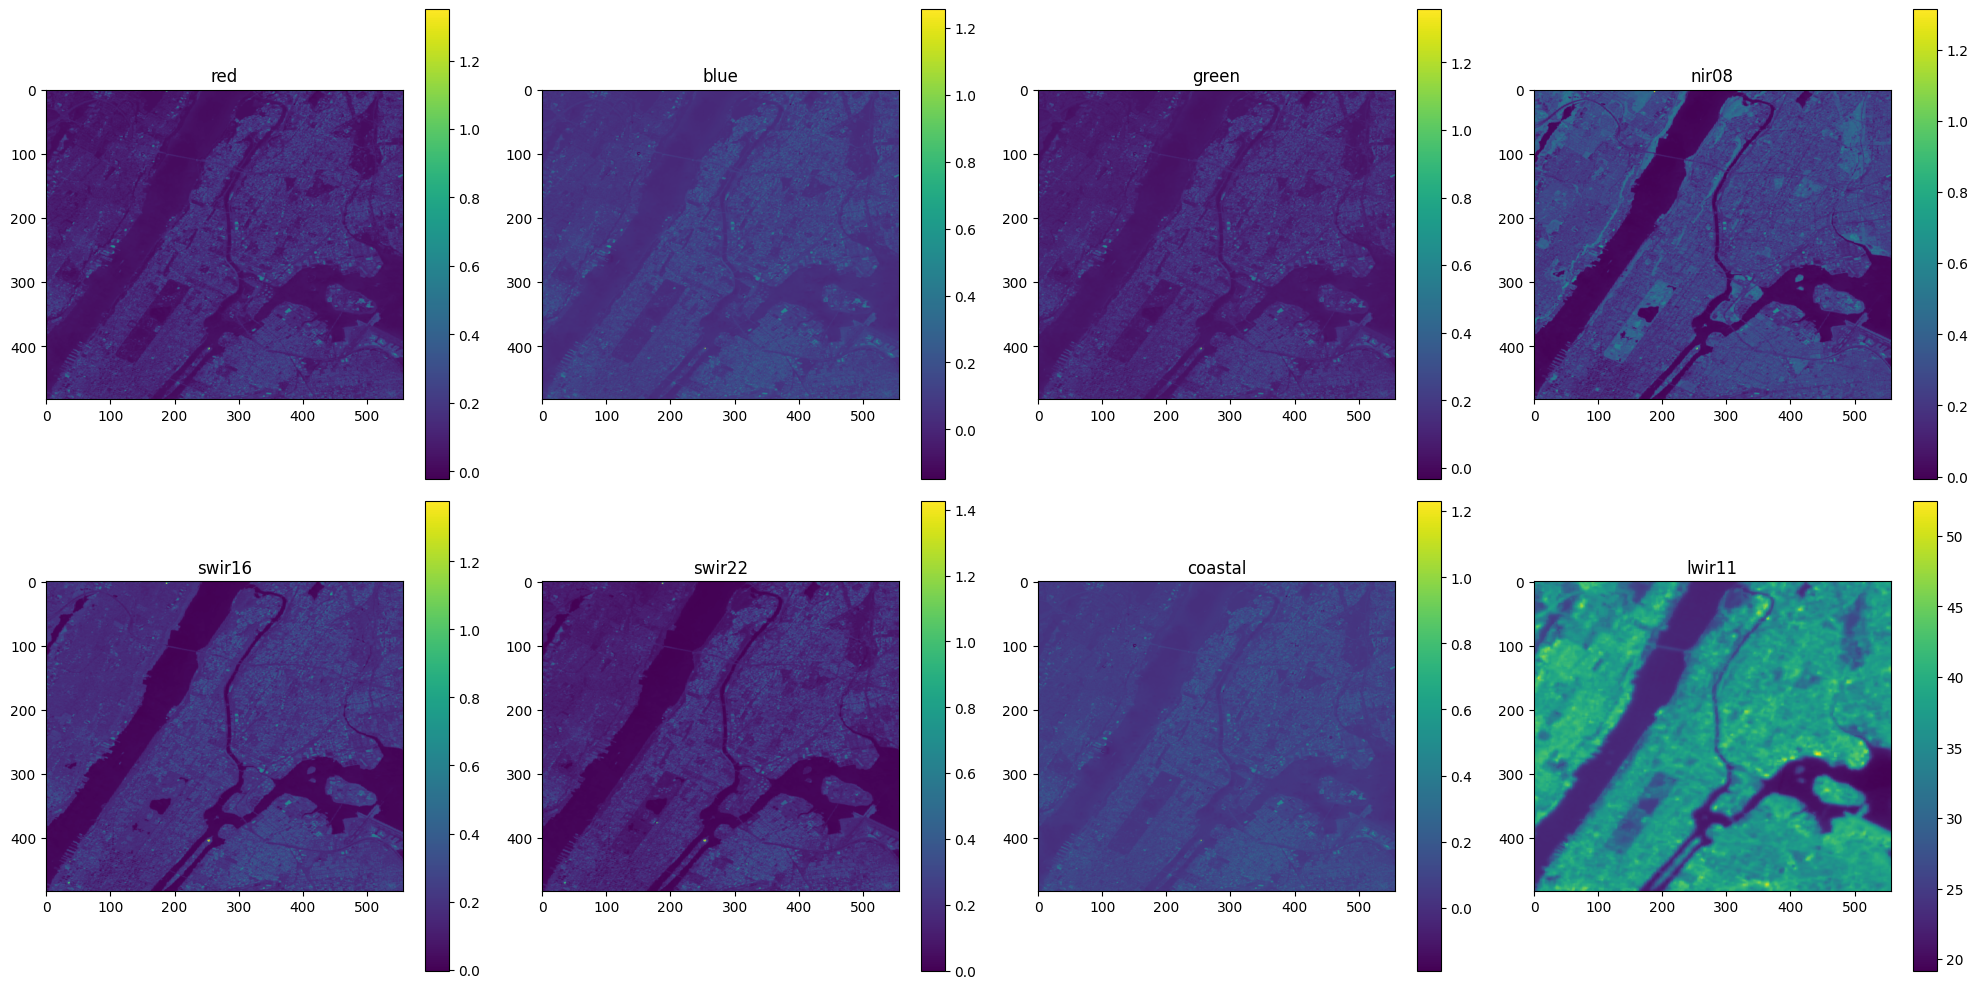

In [4]:
# Open the GeoTIFF file
tiff_path = "data_pipeline/data/tiff/landsat_8.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as dst:
    red = dst.read(1)
    blue = dst.read(2)
    green = dst.read(3)
    nir08 = dst.read(4)
    swir16 = dst.read(5)
    swir22 = dst.read(6)
    coastal = dst.read(7) 
    lwir11 = dst.read(8)

band_name = ['red', 'blue', 'green', 'nir08', 'swir16', 'swir22', 'coastal', 'lwir11'] 
band_lst = [red, blue, green, nir08, swir16, swir22, coastal, lwir11]
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

for i in range(len(band_lst)):
    im = axes[i].imshow(band_lst[i], cmap='viridis')
    axes[i].set_title(band_name[i])
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()

#### Building bands

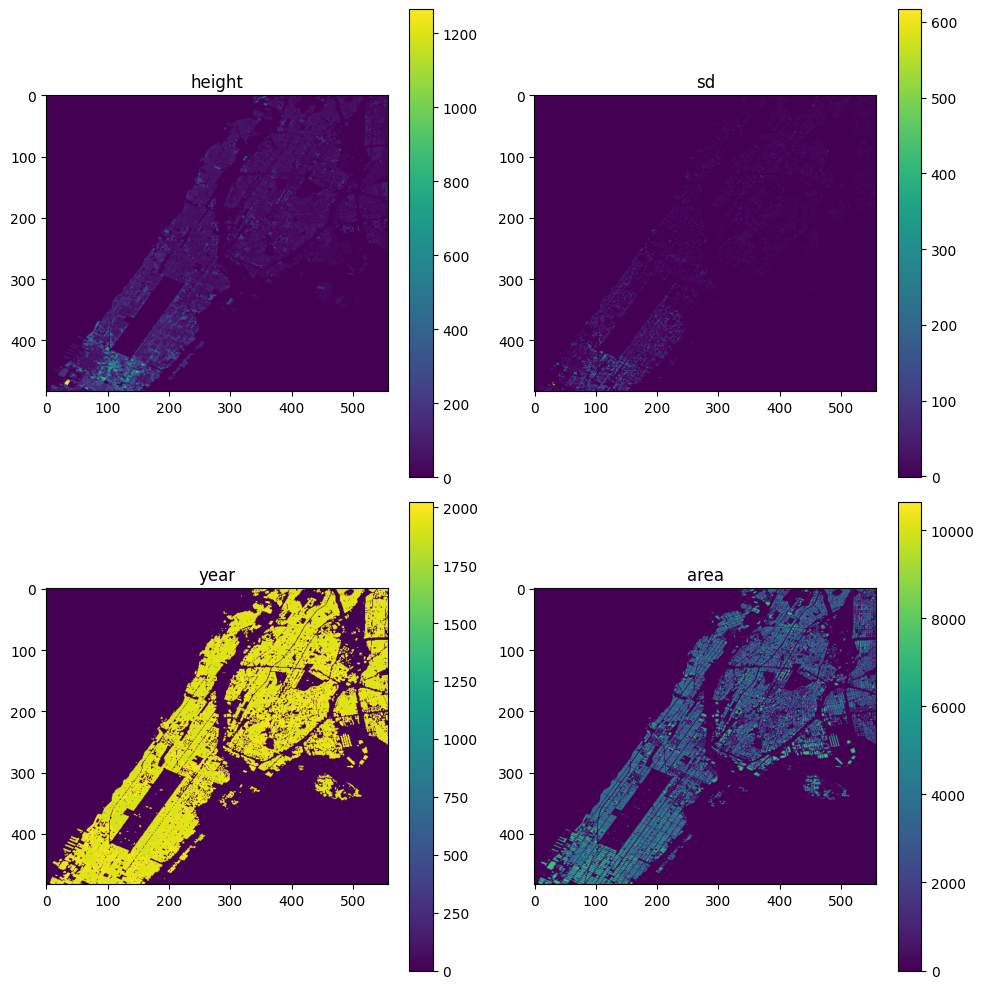

In [5]:
# Open the GeoTIFF file
tiff_path = "data_pipeline/data/tiff/building_res30.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as dst:
    building_height = dst.read(1)
    building_sd = dst.read(2)
    building_year = dst.read(3)
    building_area = dst.read(4)

band_name = ['height', 'sd', 'year', 'area']
band_lst = [building_height, building_sd, building_year, building_area]
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

for i in range(len(band_lst)):
    im = axes[i].imshow(band_lst[i], cmap='viridis')
    axes[i].set_title(band_name[i])
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()


#### Street bands

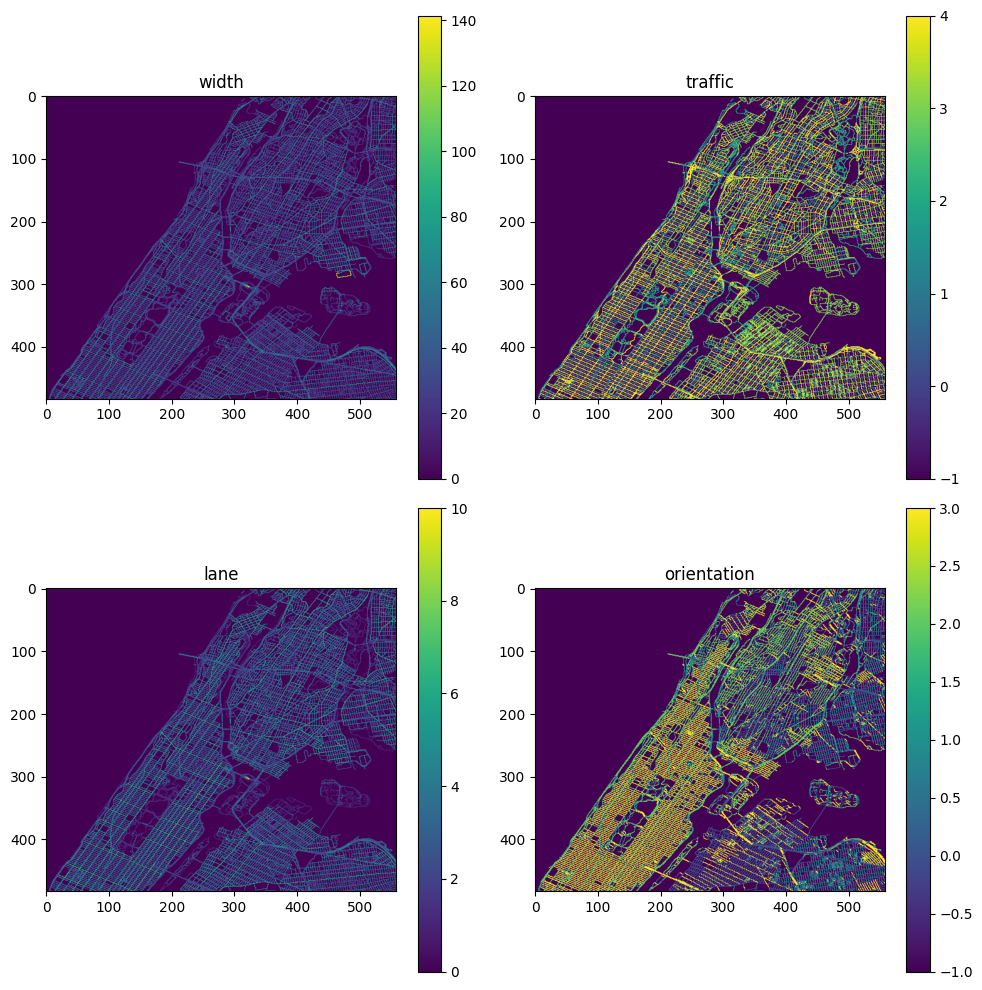

In [6]:
# Open the GeoTIFF file
tiff_path = "data_pipeline/data/tiff/street_res30.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as dst:
    street_width = dst.read(1)
    traffic_dir = dst.read(2)
    street_lane = dst.read(3)
    orientation = dst.read(4)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

band_lst = [street_width, traffic_dir, street_lane, orientation]
band_name = ['width', 'traffic', 'lane', 'orientation']

# Flatten the axes for easier indexing
axes = axes.flatten()

for i in range(len(band_lst)):
    im = axes[i].imshow(band_lst[i], cmap='viridis')
    axes[i].set_title(band_name[i])
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()


#### Air Quality bands

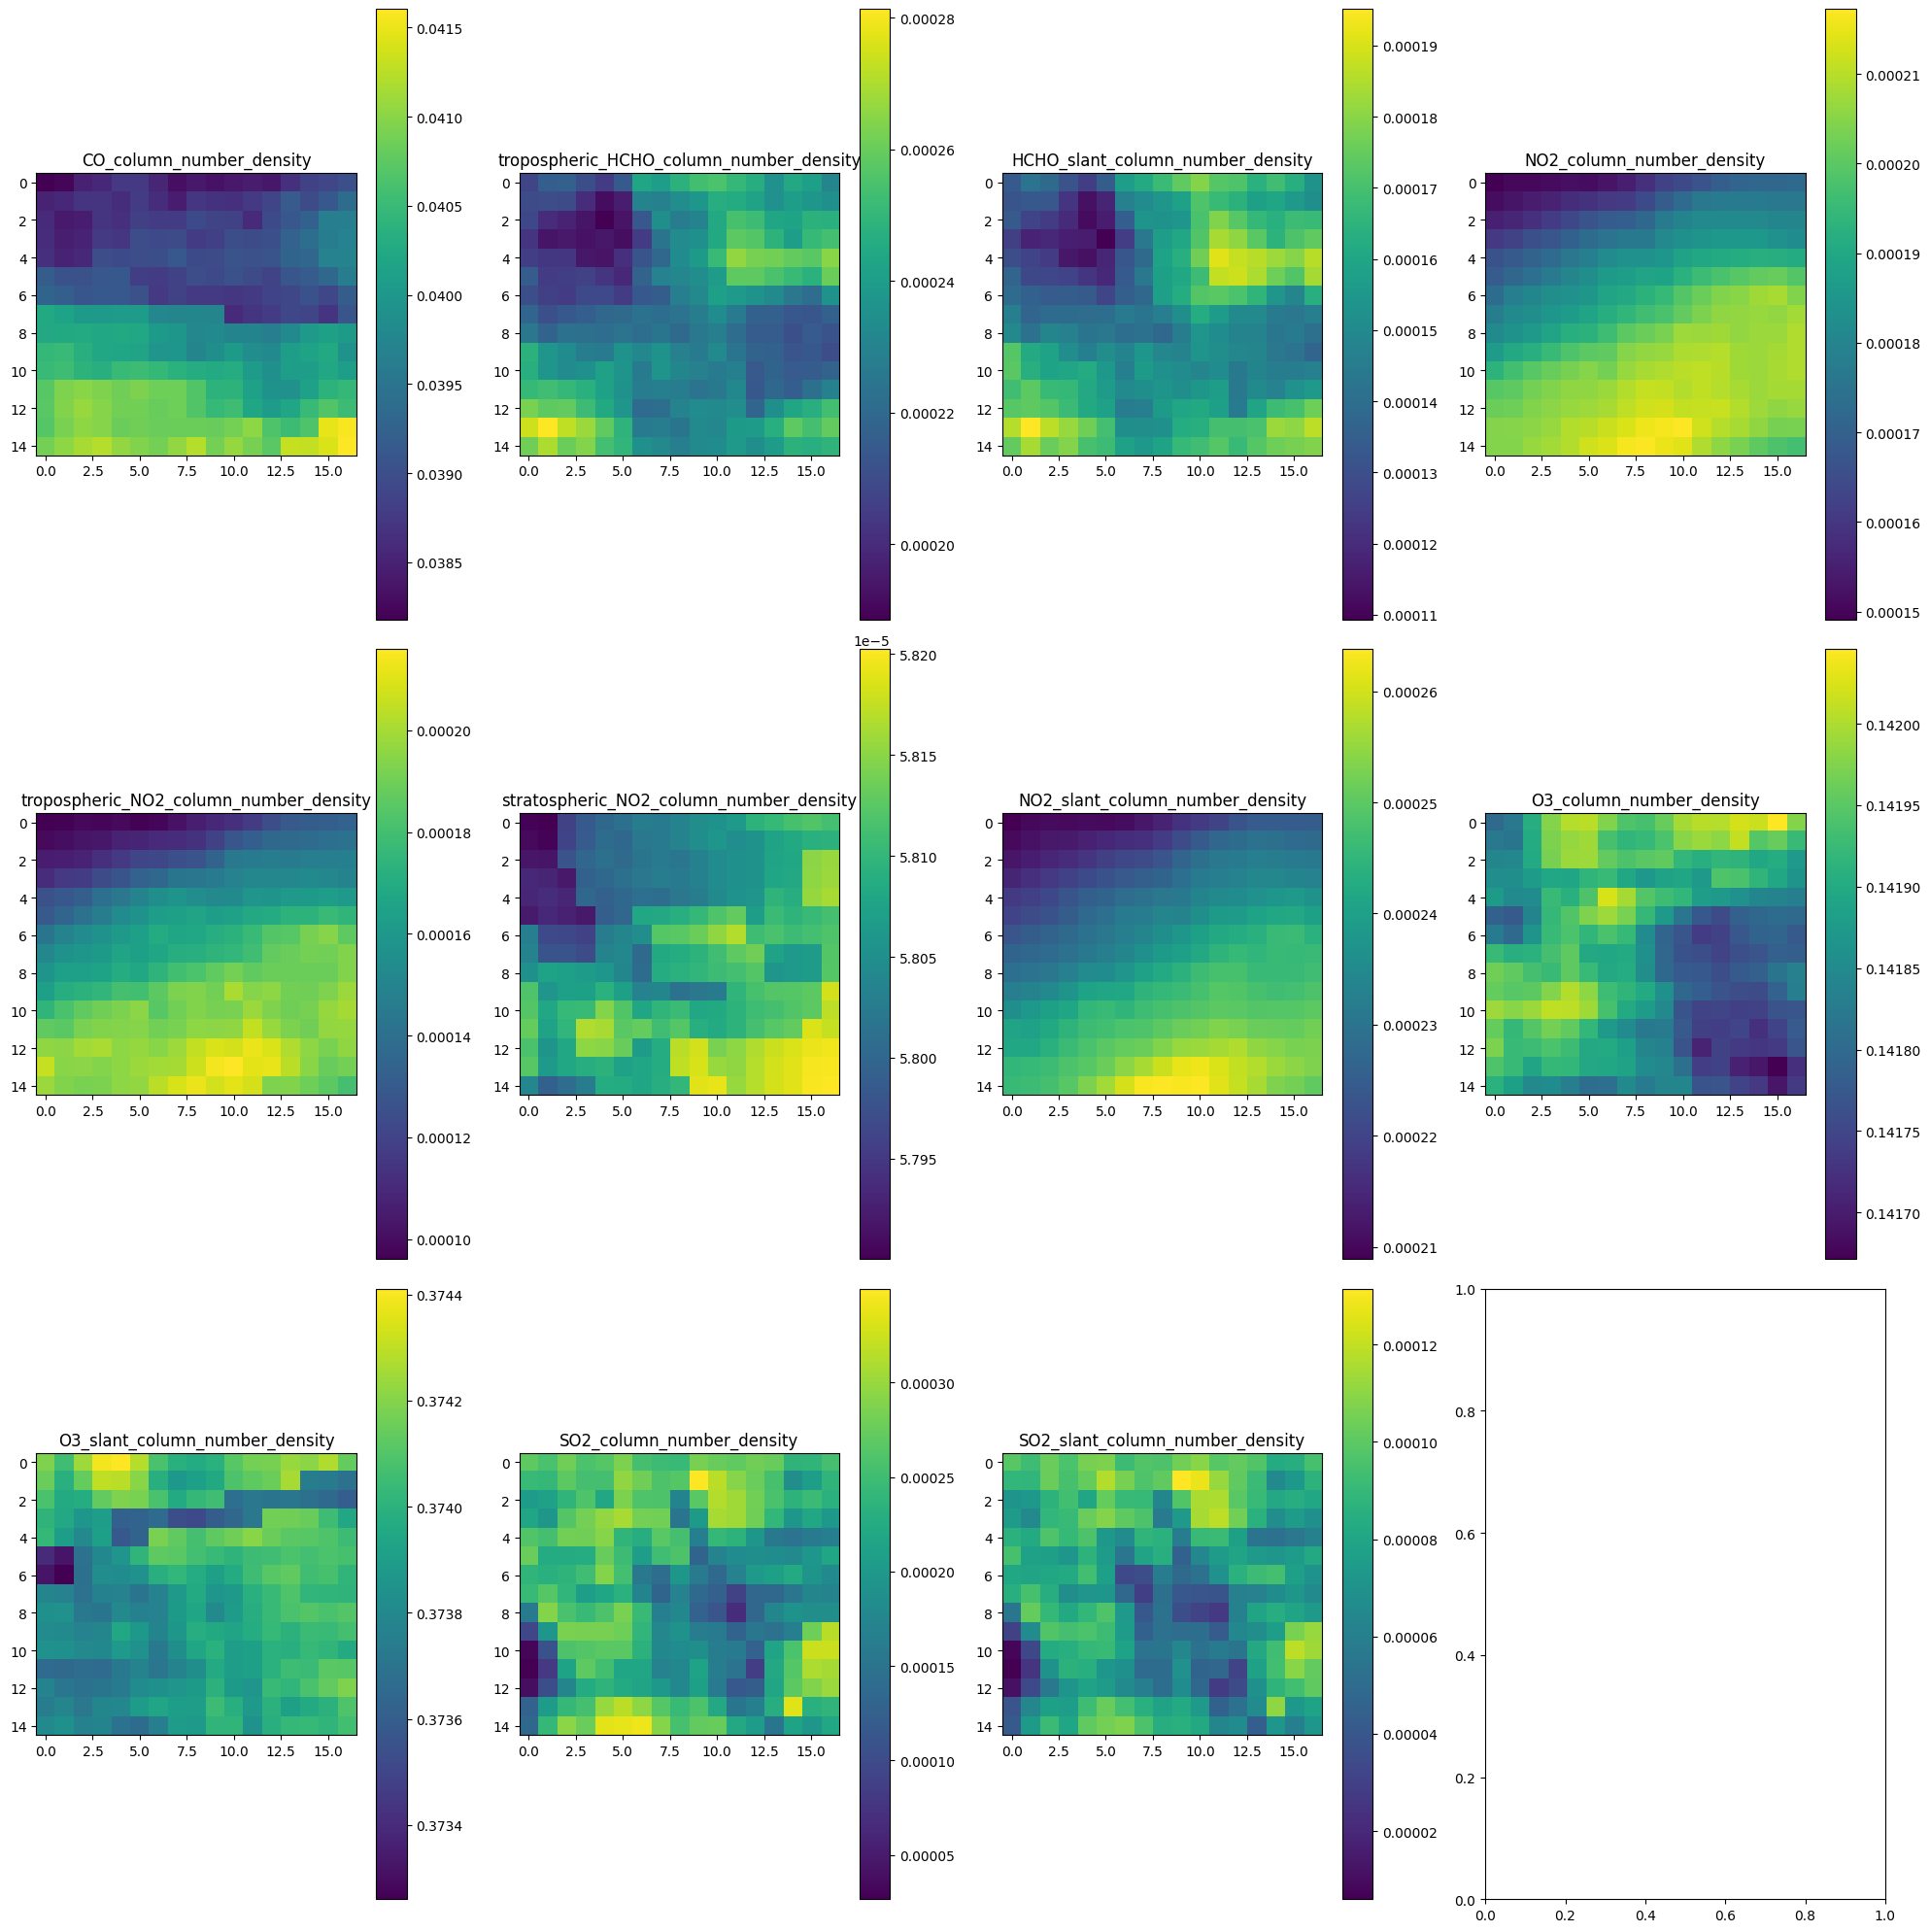

In [11]:
# # Open the GeoTIFF file
# tiff_path = "data_pipeline\\data\\air_quality\\interpolated_air_quality.tif"

# # Read the bands from the GeoTIFF file
# with rasterio.open(tiff_path) as dst:
#     co = dst.read(1)
#     so2 = dst.read(2)
#     no2 = dst.read(3)
#     o3 = dst.read(4)
#     pm25 = dst.read(5)
#     voc = dst.read(6)
#     no = dst.read(7) 
    
# air_quality_bands = ["CO", "SO2", "NO2", "O3", "PM25", "VOC", "NO"]
# band_lst = [co, so2, no2, o3, pm25, voc, no]
# fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# # Flatten the axes for easier indexing
# axes = axes.flatten()

# for i in range(len(band_lst)):
#     im = axes[i].imshow(band_lst[i], cmap='viridis')
#     axes[i].set_title(air_quality_bands[i])
#     fig.colorbar(im, ax=axes[i])

# plt.tight_layout()
# plt.show()

tif_file = "data_pipeline\\data\\air_quality\\AQ_satellite_extraction\\Merged_air_quality.tif"

co_bands = ['CO_column_number_density']
hcho_bands = [
    'tropospheric_HCHO_column_number_density',
    'HCHO_slant_column_number_density'
]
no2_bands = [
    'NO2_column_number_density',
    'tropospheric_NO2_column_number_density',
    'stratospheric_NO2_column_number_density',
    'NO2_slant_column_number_density'
]
o3_bands = [
    'O3_column_number_density',
    'O3_slant_column_number_density'
]
so2_bands = [
    'SO2_column_number_density',
    'SO2_slant_column_number_density'
]

# Read the bands from the GeoTIFF file
with rasterio.open(tif_file) as dst:
    co = dst.read(1)
    tropospheric_HCHO = dst.read(2)
    slant_HCHO = dst.read(3)
    no2 = dst.read(4)
    tropospheric_NO2 = dst.read(5)
    stratospheric_NO2= dst.read(6)
    slant_NO2 = dst.read(7)
    o3 = dst.read(8)
    slant_O3 = dst.read(9)
    so2 = dst.read(10)
    slant_SO2 = dst.read(11)

air_quality_bands = co_bands + hcho_bands + no2_bands + o3_bands + so2_bands

band_lst = [co, tropospheric_HCHO, slant_HCHO, no2, tropospheric_NO2, stratospheric_NO2, slant_NO2, o3, slant_O3, so2, slant_SO2]

fig, axes = plt.subplots(3, 4, figsize=(20, 20))

# Flatten the axes for easier indexing
axes = axes.flatten()

for i in range(len(band_lst)):
    im = axes[i].imshow(band_lst[i], cmap='viridis')
    axes[i].set_title(air_quality_bands[i])
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()

#### AOD bands

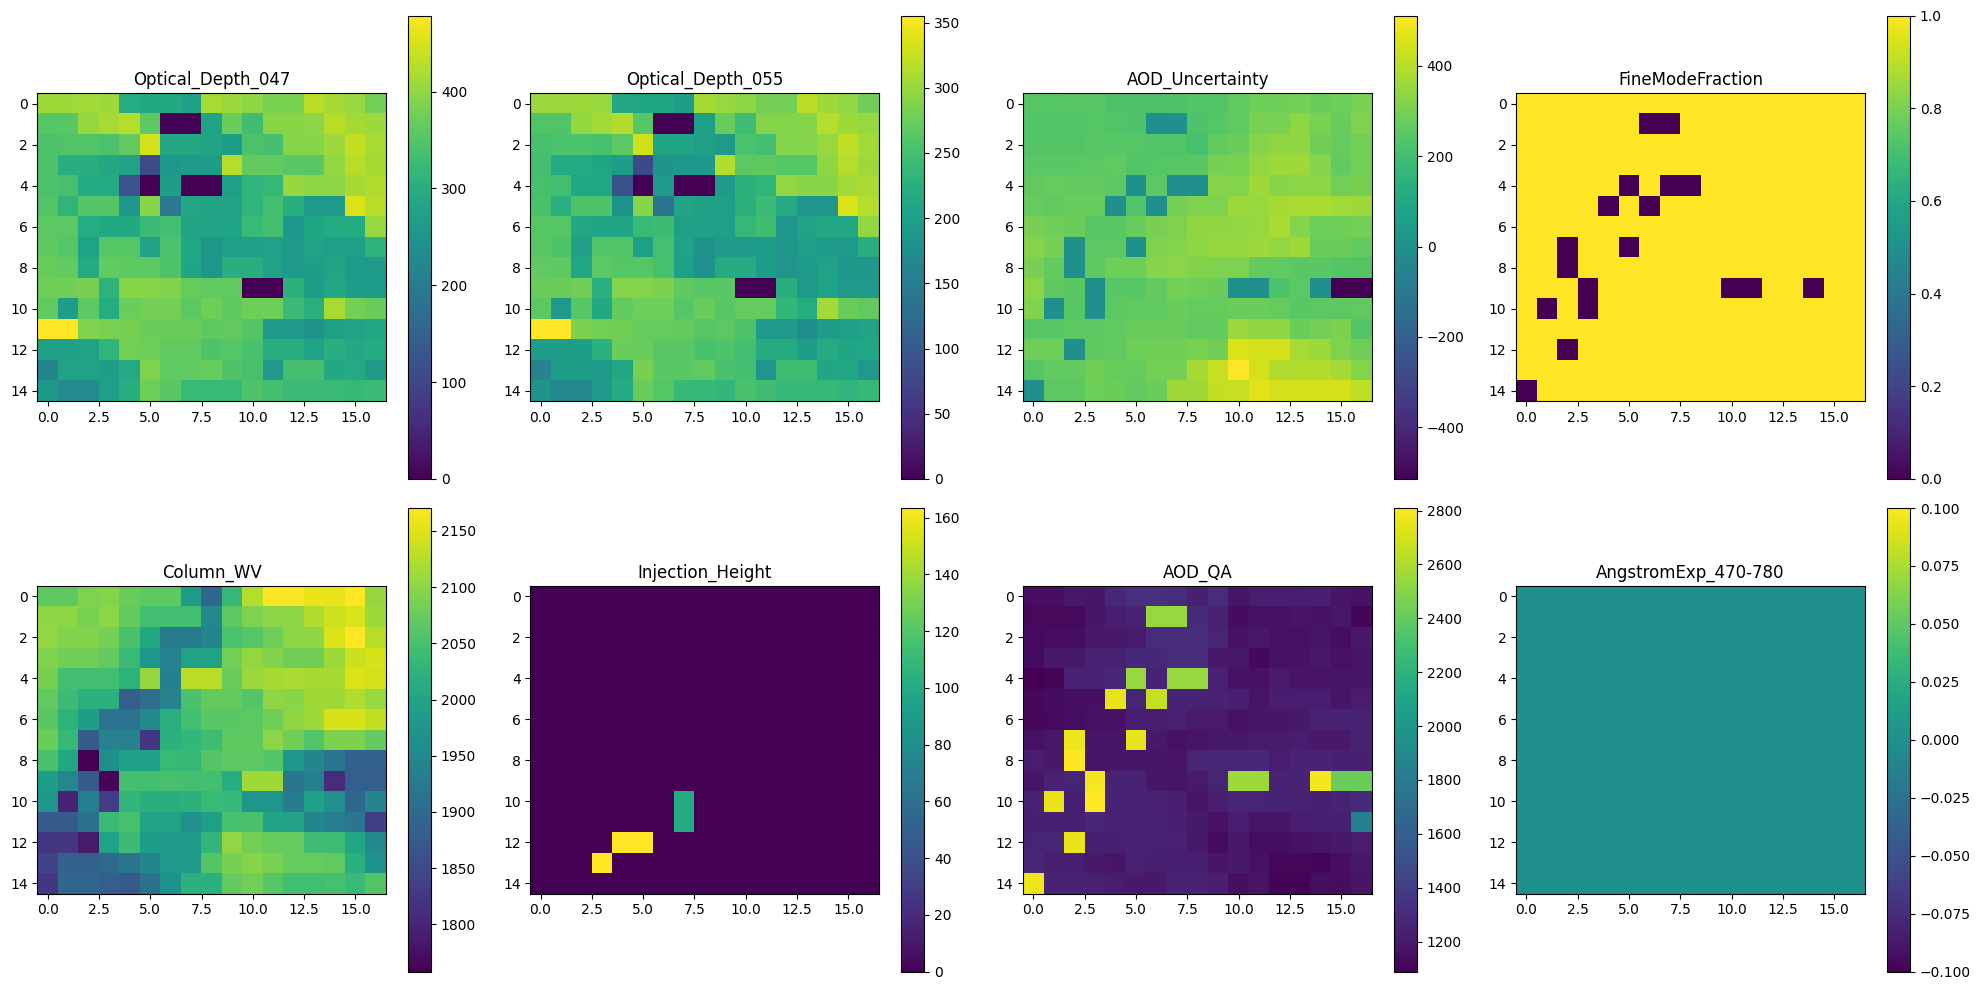

In [13]:
# Open the GeoTIFF file
tiff_path = "data_pipeline\\data\\air_quality\\AOD\\AOD_NewYork_Summer2021.tif"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as dst:
    optical_depth_047 = dst.read(1)
    optical_depth_055 = dst.read(2)
    aod_uncertainty = dst.read(3)
    fine_mode_fraction = dst.read(4)
    column_wv = dst.read(5)
    injection_height = dst.read(6)
    aod_qa = dst.read(7)
    AngstromExp_470_to_780 = dst.read(8)
    
aod_bands = [
    "Optical_Depth_047",
    "Optical_Depth_055",
    "AOD_Uncertainty",
    "FineModeFraction",
    "Column_WV",
    "Injection_Height",
    "AOD_QA",
    "AngstromExp_470-780"
    # "cosSZA",
    # "cosVZA",
    # "RelAZ",
    # "Scattering_Angle",
    # "Glint_Angle"
]

band_lst = [
    optical_depth_047,
    optical_depth_055, 
    aod_uncertainty,
    fine_mode_fraction,
    column_wv,
    injection_height,
    aod_qa,
    AngstromExp_470_to_780
]


fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

for i in range(len(band_lst)):
    im = axes[i].imshow(band_lst[i], cmap='viridis')
    axes[i].set_title(aod_bands[i])
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()

### Extracting Band Values from the GeoTIFF Image


In [14]:
training_data_path = 'data\\Training_data_uhi_index_UHI2025-v2.csv'

In [15]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.

def map_satellite_data(tiff_path, csv_path, col_name):
    
    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    layer_num = 0
    with rasterio.open(tiff_path) as dts:
        layer_num = dts.count

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values   

    df = pd.DataFrame()
    for i in tqdm(range(layer_num), desc="Go through layer"):
        values = []
        # Iterate over the latitudes and longitudes, and extract the corresponding band values
        for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
        # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)
            cell_value = data.sel(x=lon, y=lat,  band=i+1, method="nearest").values
            values.append(cell_value)
        # Add column of feature
        df[col_name[i]] = values
    
    return df


#### Landsat8 bands

In [16]:
# Mapping satellite data with training data.
data_dir = "data_pipeline/data/tiff/"
landsat_bands = ['red', 'blue', 'green', 'nir08', 'swir16', 'swir22', 'coastal', 'lwir11']
landsat_data = map_satellite_data(data_dir+'landsat_8.tiff', training_data_path,
                                landsat_bands)
landsat_data.head()

Mapping values:   0%|          | 0/11229 [00:00<?, ?it/s]

Go through layer: 100%|██████████| 8/8 [02:08<00:00, 16.12s/it]


red                 blue                green  \
0            0.0713975  0.04560249999999999  0.06952750000000002   
1            0.0713975  0.04560249999999999  0.06952750000000002   
2  0.10783500000000001              0.08875  0.10676249999999998   
3  0.10783500000000001              0.08875  0.10676249999999998   
4  0.10783500000000001              0.08875  0.10676249999999998   

                 nir08   swir16               swir22              coastal  \
0              0.20887  0.13649  0.09543249999999998  0.03925000000000001   
1              0.20887  0.13649  0.09543249999999998  0.03925000000000001   
2  0.23001749999999999    0.185            0.1352525  0.07574249999999999   
3  0.23001749999999999    0.185            0.1352525  0.07574249999999999   
4  0.23001749999999999    0.185            0.1352525  0.07574249999999999   

              lwir11  
0  37.78553354000002  
1  37.78553354000002  
2  37.35828104000001  
3  37.35828104000001  
4  37.35828104000001

#### Building bands

In [17]:
# Mapping satellite data with training data.
building_bands = ['building_height', 'building_sd', 'building_year', 'building_area']
building_data = map_satellite_data(data_dir+'building_res30.tiff', training_data_path,
                                building_bands)
building_data.head()

Go through layer: 100%|██████████| 4/4 [01:01<00:00, 15.49s/it]


building_height building_sd building_year building_area
0            65.1         0.0        1928.0      936.1115
1            65.1         0.0        1928.0      936.1115
2             0.0        -1.0           0.0           0.0
3             0.0        -1.0           0.0           0.0
4             0.0        -1.0           0.0           0.0

#### Street bands

In [18]:
# Mapping satellite data with training data.
street_bands = ['street_width', 'street_traffic', 'street_lane', 'street_orientation']
street_data = map_satellite_data(data_dir+'street_res30.tiff', training_data_path,
                                street_bands)
street_data.head()

Go through layer:   0%|          | 0/4 [00:00<?, ?it/s]

Go through layer: 100%|██████████| 4/4 [01:07<00:00, 16.82s/it]


street_width street_traffic street_lane street_orientation
0         44.0            4.0         4.0                1.0
1         44.0            4.0         4.0                1.0
2         31.0            1.0   2.3333333                1.0
3         31.0            1.0   2.3333333                1.0
4         31.0            1.0   2.3333333                1.0

#### Air Quality bands

In [19]:
tif_file_path = "data_pipeline\\data\\air_quality\\AQ_satellite_extraction\\Merged_air_quality.tif"

co_bands = ['CO_column_number_density']
hcho_bands = [
    'tropospheric_HCHO_column_number_density',
    'HCHO_slant_column_number_density'
]
no2_bands = [
    'NO2_column_number_density',
    'tropospheric_NO2_column_number_density',
    'stratospheric_NO2_column_number_density',
    'NO2_slant_column_number_density'
]
o3_bands = [
    'O3_column_number_density',
    'O3_slant_column_number_density'
]
so2_bands = [
    'SO2_column_number_density',
    'SO2_slant_column_number_density'
]

air_quality_bands = co_bands + hcho_bands + no2_bands + o3_bands + so2_bands

air_quality_data = map_satellite_data(csv_path=training_data_path, 
                                      tiff_path=tif_file_path,
                                      col_name=air_quality_bands)
air_quality_data

Go through layer:   0%|          | 0/11 [00:00<?, ?it/s]

Go through layer: 100%|██████████| 11/11 [04:05<00:00, 22.32s/it]


CO_column_number_density tropospheric_HCHO_column_number_density  \
0         0.038712807240095716                  0.00022637703762824076   
1         0.038712807240095716                  0.00022637703762824076   
2         0.038712807240095716                  0.00022637703762824076   
3         0.038712807240095716                  0.00022637703762824076   
4         0.038712807240095716                  0.00022637703762824076   
...                        ...                                     ...   
11224      0.04045852378097224                  0.00022679462639649804   
11225      0.04045852378097224                  0.00022679462639649804   
11226      0.04045852378097224                  0.00022679462639649804   
11227      0.04045852378097224                  0.00022679462639649804   
11228      0.04045852378097224                  0.00022679462639649804   

      HCHO_slant_column_number_density NO2_column_number_density  \
0               0.00015662625523033124     0.0002038722732279705   
1               0.00015662625523033124     0.0002038722732279705   
2               0.00015662625523033124     0.0002038722732279705   
3               0.00015662625523033124     0.0002038722732279705   
4               0.00015662625523033124     0.0002038722732279705   
...                                ...                       ...   
11224           0.00014651611561325957    0.00020301659816050416   
11225           0.00014651611561325957    0.00020301659816050416   
11226           0.00014651611561325957    0.00020301659816050416   
11227           0.00014651611561325957    0.00020301659816050416   
11228           0.00014651611561325957    0.00020301659816050416   

      tropospheric_NO2_column_number_density  \
0                     0.00017919077451441966   
1                     0.00017919077451441966   
2                     0.00017919077451441966   
3                     0.00017919077451441966   
4                     0.00017919077451441966   
...                                      ...   
11224                  0.0001849719342011486   
11225                  0.0001849719342011486   
11226                  0.0001849719342011486   
11227                  0.0001849719342011486   
11228                  0.0001849719342011486   

      stratospheric_NO2_column_number_density NO2_slant_column_number_density  \
0                       5.812764644561164e-05           0.0002445740426548214   
1                       5.812764644561164e-05           0.0002445740426548214   
2                       5.812764644561164e-05           0.0002445740426548214   
3                       5.812764644561164e-05           0.0002445740426548214   
4                       5.812764644561164e-05           0.0002445740426548214   
...                                       ...                             ...   
11224                  5.8078591174047414e-05          0.00024492661706428717   
11225                  5.8078591174047414e-05          0.00024492661706428717   
11226                  5.8078591174047414e-05          0.00024492661706428717   
11227                  5.8078591174047414e-05          0.00024492661706428717   
11228                  5.8078591174047414e-05          0.00024492661706428717   

      O3_column_number_density O3_slant_column_number_density  \
0           0.1417619827213424             0.3739885526556617   
1           0.1417619827213424             0.3739885526556617   
2           0.1417619827213424             0.3739885526556617   
3           0.1417619827213424             0.3739885526556617   
4           0.1417619827213424             0.3739885526556617   
...                        ...                            ...   
11224      0.14193732529896352            0.37372362488854555   
11225      0.14193732529896352            0.37372362488854555   
11226      0.14193732529896352            0.37372362488854555   
11227      0.14193732529896352            0.37372362488854555   
11228      0.14193732529896352     

#### AOD bands

In [21]:
tif_path = "data_pipeline\\data\\air_quality\\AOD\\AOD_NewYork_Summer2021.tif"
aod_bands = [ 
    "Optical_Depth_047",
    "Optical_Depth_055",
    "AOD_Uncertainty",
    "FineModeFraction",
    "Column_WV",
    "Injection_Height",
    "AOD_QA",
    "AngstromExp_470-780"
]
aod_data = map_satellite_data(csv_path=training_data_path,
                              tiff_path=tif_path,
                              col_name=aod_bands)


Go through layer:   0%|          | 0/8 [00:00<?, ?it/s]

Go through layer: 100%|██████████| 8/8 [01:54<00:00, 14.31s/it]


In [23]:
df = pd.read_csv('data/Training_data_uhi_index_UHI2025-v2.csv')
df = pd.concat([df, landsat_data, building_data, street_data, air_quality_data, aod_data], axis=1)

df

Longitude   Latitude          datetime  UHI Index                  red  \
0     -73.909167  40.813107  24-07-2021 15:53   1.030289            0.0713975   
1     -73.909187  40.813045  24-07-2021 15:53   1.030289            0.0713975   
2     -73.909215  40.812978  24-07-2021 15:53   1.023798  0.10783500000000001   
3     -73.909242  40.812908  24-07-2021 15:53   1.023798  0.10783500000000001   
4     -73.909257  40.812845  24-07-2021 15:53   1.021634  0.10783500000000001   
...          ...        ...               ...        ...                  ...   
11224 -73.957050  40.790333  24-07-2021 15:57   0.972470              0.06488   
11225 -73.957063  40.790308  24-07-2021 15:57   0.972470              0.06488   
11226 -73.957093  40.790270  24-07-2021 15:57   0.981124              0.06488   
11227 -73.957112  40.790253  24-07-2021 15:59   0.981245              0.06488   
11228 -73.957128  40.790237  24-07-2021 15:59   0.983408              0.06488   

                      blue                green                nir08  \
0      0.04560249999999999  0.06952750000000002              0.20887   
1      0.04560249999999999  0.06952750000000002              0.20887   
2                  0.08875  0.10676249999999998  0.23001749999999999   
3                  0.08875  0.10676249999999998  0.23001749999999999   
4                  0.08875  0.10676249999999998  0.23001749999999999   
...                    ...                  ...                  ...   
11224  0.05126750000000002  0.07579750000000002             0.336745   
11225  0.05126750000000002  0.07579750000000002             0.336745   
11226  0.05126750000000002  0.07579750000000002             0.336745   
11227  0.05126750000000002  0.07579750000000002             0.336745   
11228  0.05126750000000002  0.07579750000000002             0.336745   

                    swir16               swir22  ...  \
0                  0.13649  0.09543249999999998  ...   
1                  0.13649  0.09543249999999998  ...   
2                    0.185            0.1352525  ...   
3                    0.185            0.1352525  ...   
4                    0.185            0.1352525  ...   
...                    ...                  ...  ...   
11224  0.18282749999999998            0.1048925  ...   
11225  0.18282749999999998            0.1048925  ...   
11226  0.18282749999999998            0.1048925  ...   
11227  0.18282749999999998            0.1048925  ...   
11228  0.18282749999999998            0.1048925  ...   

      SO2_column_number_density SO2_slant_column_number_density  \
0         9.064841756796388e-05           3.851703072315605e-05   
1         9.064841756796388e-05           3.851703072315605e-05   
2         9.064841756796388e-05           3.851703072315605e-05   
3         9.064841756796388e-05           3.851703072315605e-05   
4         9.064841756796388e-05           3.851703072315605e-05   
...                         ...                             ...   
11224    0.00023411176223837987           7.889882963271087e-05   
11225    0.00023411176223837987           7.889882963271087e-05   
11226    0.00023411176223837987           7.889882963271087e-05   
11227    0.00023411176223837987           7.889882963271087e-05   
11228    0.00023411176223837987           7.889882963271087e-05   

        Optical_Depth_047   Optical_Depth_055     AOD_Uncertainty  \
0      275.17241379310343   198.9655172413793  361.60093896713613   
1      275.17241379310343   198.9655172413793  361.60093896713613   
2      275.17241379310343   198.9655172413793  361.60093896713613   
3      275.17241379310343   198.9655172413793  361.60093896713613   
4      275.17241379310343   198.9655172413793  361.60093896713613   
...                   ...                 ...                 ...   
11224   379.1162790697674  276.93023255813955   261.6192660550459   
11225   379.1162790697674  276.93023255813955   261.6192660550459   
11226   379.1162790697674  276.93023255813955   261.6192660550459   
1

### Environmental Indices


In [24]:
# NDVI (Normalized Difference Vegetation Index) 
df['ndvi'] = (df['nir08'] - df['red']) / (df['nir08'] + df['red'])

# EVI (Enhanced Vegetation Index)
df["evi"] = 2.5 * (df['nir08'] - df['red']) / (df['nir08'] + 6 * df['red'] - 7.5 * df['blue'] + 1 + 1e-10)

# SAVI (Soil Adjusted Vegetation Index)
df["savi"] = (df['nir08'] - df['red']) * 1.5 / (df['nir08'] + df['red'] + 0.5 + 1e-10)

# GNDVI (Green Normalized Difference Vegetation Index)
df["gndvi"] = (df['nir08'] - df['green']) / (df['nir08'] + df['green'] + 1e-10)

# ARVI (Atmospherically Resistant Vegetation Index)
df["arvi"] = (df['nir08'] - (df['red'] - (df['blue'] - df['red']))) / (df['nir08'] + (df['red'] - (df['blue'] - df['red'])) + 1e-10)

# MSAVI (Modified Soil-Adjusted Vegetation Index)
df["msavi"] = (2 * df['nir08'] + 1 - ((2 * df['nir08'] + 1) ** 2 - 8 * (df['nir08'] - df['red'])) ** 0.5) / 2

# NDWI (Normalized Difference Water Index)
df['ndwi'] = (df['green'] - df['nir08']) / (df['green'] + df['nir08'])

# MNDWI (Modified Normalized Difference Water Index)
df["mndwi"] = (df['green'] - df['swir16']) / (df['green'] + df['swir16'] + 1e-10)

# AWEI_NSH (Automated Water Extraction Index - No Shadows)
df["awei_nsh"] = 4 * (df['green'] - df['swir16']) - (0.25 * df['nir08'] + 2.75 * df['swir22'])

# AWEI_SH (Automated Water Extraction Index - Shadows)
df["awei_sh"] = df['green'] + 2.5 * df['nir08'] - 1.5 * (df['swir16'] + df['swir22']) - 0.25 * df['blue']

# NDSI (Normalized Difference Snow Index)
df["ndsi"] = (df['green'] - df['swir16']) / (df['green'] + df['swir16'] + 1e-10)

# NBR (Normalized Burn Ratio)
df["nbr"] = (df['nir08'] - df['swir22']) / (df['nir08'] + df['swir22'] + 1e-10)

# SI (Shadow Index or Soil Index)
df["si"] = (df['swir16'] - df['blue']) / (df['swir16'] + df['blue'] + 1e-10)
    
# NDBI (Normalized Difference Building Index)
df['ndbi'] = (df['swir16'] - df['nir08']) / (df['swir16'] + df['nir08'])

# UI (Urban Index)
df["ui"] = (df['swir16'] - df['red']) / (df['swir16'] + df['red'] + 1e-10)

# IBI (Index-based Built-up Index)
df["ibi"] = (df["ndbi"] - (df["savi"] + df["mndwi"])) / (df["ndbi"] + (df["savi"] + df["mndwi"]) + 1e-10)
                                                         
# Albedo (Surface Reflectance Index)
df['albedo'] = (0.356 * df['blue'] + 0.130 * df['red'] + 0.373 * df['nir08'] + 0.085 * df['swir16'] + 0.072 * df['swir22'] - 0.018) / 1.016


### VAR (Vertical Aspect Ratio) and Building Area per Pixel


In [25]:
# Calculate the VAR (Vertical Aspect Ratio)
df['VAR'] = df['building_height'] / df['street_width']
df['VAR'] = df['VAR'].replace([np.inf, -np.inf], np.nan)

# Calculate the building's area per pixel area (30 x 30 m^2)
df['Building_area_per_pixel'] = df['building_area'] / (900 * 10.764)
df['Building_area_per_pixel'] = df['Building_area_per_pixel'].replace([np.inf, -np.inf], np.nan)

In [ ]:
# air_quality_files = {
#     "CO": "data_pipeline\\data\\air_quality\\co_data_mean_and_std.csv",
#     "SO2": "data_pipeline\\data\\air_quality\\so2_data_mean_and_std.csv",
#     "NO2": "data_pipeline\\data\\air_quality\\no2_data_mean_and_std.csv",
#     "O3": "data_pipeline\\data\\air_quality\\o3_data_mean_and_std.csv",
#     # "PM10": "data_pipeline\\data\\air_quality\\pm10_data_mean_and_std.csv",
#     "PM25": "data_pipeline\\data\\air_quality\\pm2.5_data_mean_and_std.csv",
#     "VOC": "data_pipeline\\data\\air_quality\\voc_data_mean_and_std.csv",
#     "NO": "data_pipeline\\data\\air_quality\\no_data_mean_and_std.csv",
# }

# Iterate over each air quality dataset and map values using KNN
# for key, file_path in air_quality_files.items():
#     # Load the air quality dataset
#     air_quality_data = pd.read_csv(file_path)
    
#     # Extract coordinates and values
#     aq_coords = air_quality_data[["longitude", "latitude"]].values
#     avg_values = air_quality_data[f"average_{key}"].values
#     std_values = air_quality_data[f"std_{key}"].values
    
#     # Create KDTree for nearest neighbor search
#     tree = cKDTree(aq_coords)
    
#     # Find the nearest point for each coordinate in the main dataset
#     distances, indices = tree.query(df[['Longitude', 'Latitude']], k=1)  # k=1 means nearest neighbor
    
#     # Assign values to the main dataset
#     df[f"Mean_nearest_{key}"] = avg_values[indices]
#     df[f"Std_{key}"] = std_values[indices]
    
# def idw_interpolation(air_quality_file, param_name, power=1):
#     """ Apply IDW interpolation for a given air quality parameter. """
    
#     # Load air quality data
#     air_quality_df = pd.read_csv(air_quality_file)
    
#     # Extract known data points
#     known_lons = air_quality_df["longitude"].values
#     known_lats = air_quality_df["latitude"].values
#     known_values = air_quality_df["average_" + param_name].values  # Using mean values
    
#     # Create KDTree for fast nearest neighbor search
#     tree = cKDTree(list(zip(known_lons, known_lats)))

#     # Perform interpolation for each point in df
#     interpolated_values = []
#     for lon, lat in zip(df["Longitude"], df["Latitude"]):
#         distances, indices = tree.query([lon, lat], k=len(known_lons))  # Use all available points

#         if len(known_values) < 2:
#             interpolated_values.append(np.nan)
#             continue

#         weights = 1 / (distances**power + 1e-10)
#         interpolated_value = np.sum(weights * known_values[indices]) / np.sum(weights)
#         interpolated_values.append(interpolated_value)

#     # Add interpolated values to df
#     df["Interpolated_" + param_name] = interpolated_values

# # Apply IDW for each air quality parameter
# for param, file_path in air_quality_files.items():
#     idw_interpolation(file_path, param)

# def idw_interpolation_to_raster(csv_files, output_raster, raster_size=(558, 484), power=1):
#     """
#     Interpolates air quality data from multiple CSV files into a raster using IDW.

#     Parameters:
#     - csv_files: dict, mapping parameter names to CSV file paths.
#     - output_raster: str, path to save the output raster.
#     - raster_size: tuple, (width, height) of the raster.
#     - power: float, inverse distance weighting power.
#     """
    
#     # Define raster boundaries (manually or from data)
#     min_x, min_y, max_x, max_y = -74.01, 40.75, -73.86, 40.88  # New York bounding box
#     width, height = raster_size
#     pixel_size_x = (max_x - min_x) / width
#     pixel_size_y = (max_y - min_y) / height

#     # Create grid coordinates
#     x_coords = np.linspace(min_x, max_x, width)
#     y_coords = np.linspace(min_y, max_y, height)
#     grid_x, grid_y = np.meshgrid(x_coords, y_coords)

#     # Create an empty raster stack
#     raster_stack = np.zeros((len(csv_files), height, width), dtype=np.float32)

#     for i, (param, file_path) in enumerate(csv_files.items()):
#         # Load CSV data
#         df = pd.read_csv(file_path)
#         known_lons = df["longitude"].values
#         known_lats = df["latitude"].values
#         known_values = df["average_" + param].values

#         # Build KDTree for fast lookup
#         tree = cKDTree(list(zip(known_lons, known_lats)))

#         # Flatten grid coordinates for batch query
#         grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T
#         distances, indices = tree.query(grid_points, k=len(known_lons))
        
#         # Compute IDW interpolation
#         weights = 1 / (distances ** power + 1e-10)
        
#         # print(f"weights.shape: {weights.shape}")
#         # print(f"indices.shape: {indices.shape}")
#         # print(f"known_values.shape: {known_values.shape}")
#         # print(f"known_values[indices].shape: {known_values[indices].shape}")
        
#         interpolated_values = np.sum(weights * known_values[indices], axis=1) / np.sum(weights, axis=1)

#         # Reshape back to raster format
#         raster_stack[i] = interpolated_values.reshape(height, width)

#     # Define raster transformation
#     transform = from_origin(min_x, max_y, pixel_size_x, pixel_size_y)

#     # Save the raster as GeoTIFF
#     with rasterio.open(
#         output_raster, "w",
#         driver="GTiff",
#         height=height,
#         width=width,
#         count=len(csv_files),
#         dtype=rasterio.float32,
#         crs="EPSG:4326",
#         transform=transform
#     ) as dst:
#         for i, (param, file_path) in enumerate(csv_files.items()):
#             dst.write(raster_stack[i], i + 1)
#             dst.set_band_description(i + 1, param)

#     print(f"Raster saved at {output_raster}")

# idw_interpolation_to_raster(air_quality_files, "data_pipeline\\data\\air_quality\\interpolated_air_quality.tif")

# AOD (Aerosol Optical Depth)
# df['AOD'] = df['blue'] / df['red'] + 1e-10

In [20]:
# # AOD (Aerosol Optical Depth)
# df['AOD'] = df['blue'] / df['red'] + 1e-10

# # PM2.5
# conversion_factor = 52
# df['PM_2.5'] = df['AOD'] * conversion_factor + 1e-10

# # NO2
# df['NO2'] = df['blue'] / df['green'] + 1e-10

# # SO2
# df['SO2'] = df['swir16'] - df['swir22'] + 1e-10

## EDA

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 58 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Longitude                                11229 non-null  float64
 1   Latitude                                 11229 non-null  float64
 2   datetime                                 11229 non-null  object 
 3   UHI Index                                11229 non-null  float64
 4   red                                      11229 non-null  object 
 5   blue                                     11229 non-null  object 
 6   green                                    11229 non-null  object 
 7   nir08                                    11229 non-null  object 
 8   swir16                                   11229 non-null  object 
 9   swir22                                   11229 non-null  object 
 10  coastal                                  11229

In [28]:
excluded_cols = ['Longitude', 'Latitude', 'datetime', 'UHI Index']
categorical_cols = ['street_traffic', 'street_orientation']

excluded_feautures = [
    # 'Building_area_per_pixel', 
    # 'ndsi', 
    # 'FineModeFraction', 
    # 'AngstromExp_470-780', 
    # 'awei_sh', 
    # 'mndwi', 
    # 'gndvi', 
    # 'si', 
    # 'green', 
    # 'building_year', 
    # 'red', 
    # 'ui', 
    # 'building_sd',
    # 'blue',
    # 'swir16',
    # 'VAR',
    # 'building_area',
    # 'Optical_Depth_055',
    # 'ndwi',
    # 'savi',
    # 'evi',
    # 'msavi',
    # 'arvi',
    # 'ndvi',
    # 'nbr',
    # 'swir22',
    # 'coastal',
    # 'nir08',
    # 'albedo',
    # 'ibi',
    # 'building_height',
    # 'awei_nsh',
    # 'Injection_Height',
    # 'ndbi',
]

numerical_cols = df.columns.difference(categorical_cols + excluded_cols + excluded_feautures)

In [29]:
df[numerical_cols] = df[numerical_cols].astype('float')

In [30]:
df[categorical_cols] = df[categorical_cols].astype('float')
df[categorical_cols] = df[categorical_cols].astype('category')

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 58 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   Longitude                                11229 non-null  float64 
 1   Latitude                                 11229 non-null  float64 
 2   datetime                                 11229 non-null  object  
 3   UHI Index                                11229 non-null  float64 
 4   red                                      11229 non-null  float64 
 5   blue                                     11229 non-null  float64 
 6   green                                    11229 non-null  float64 
 7   nir08                                    11229 non-null  float64 
 8   swir16                                   11229 non-null  float64 
 9   swir22                                   11229 non-null  float64 
 10  coastal                           

### Mising values

<Axes: >

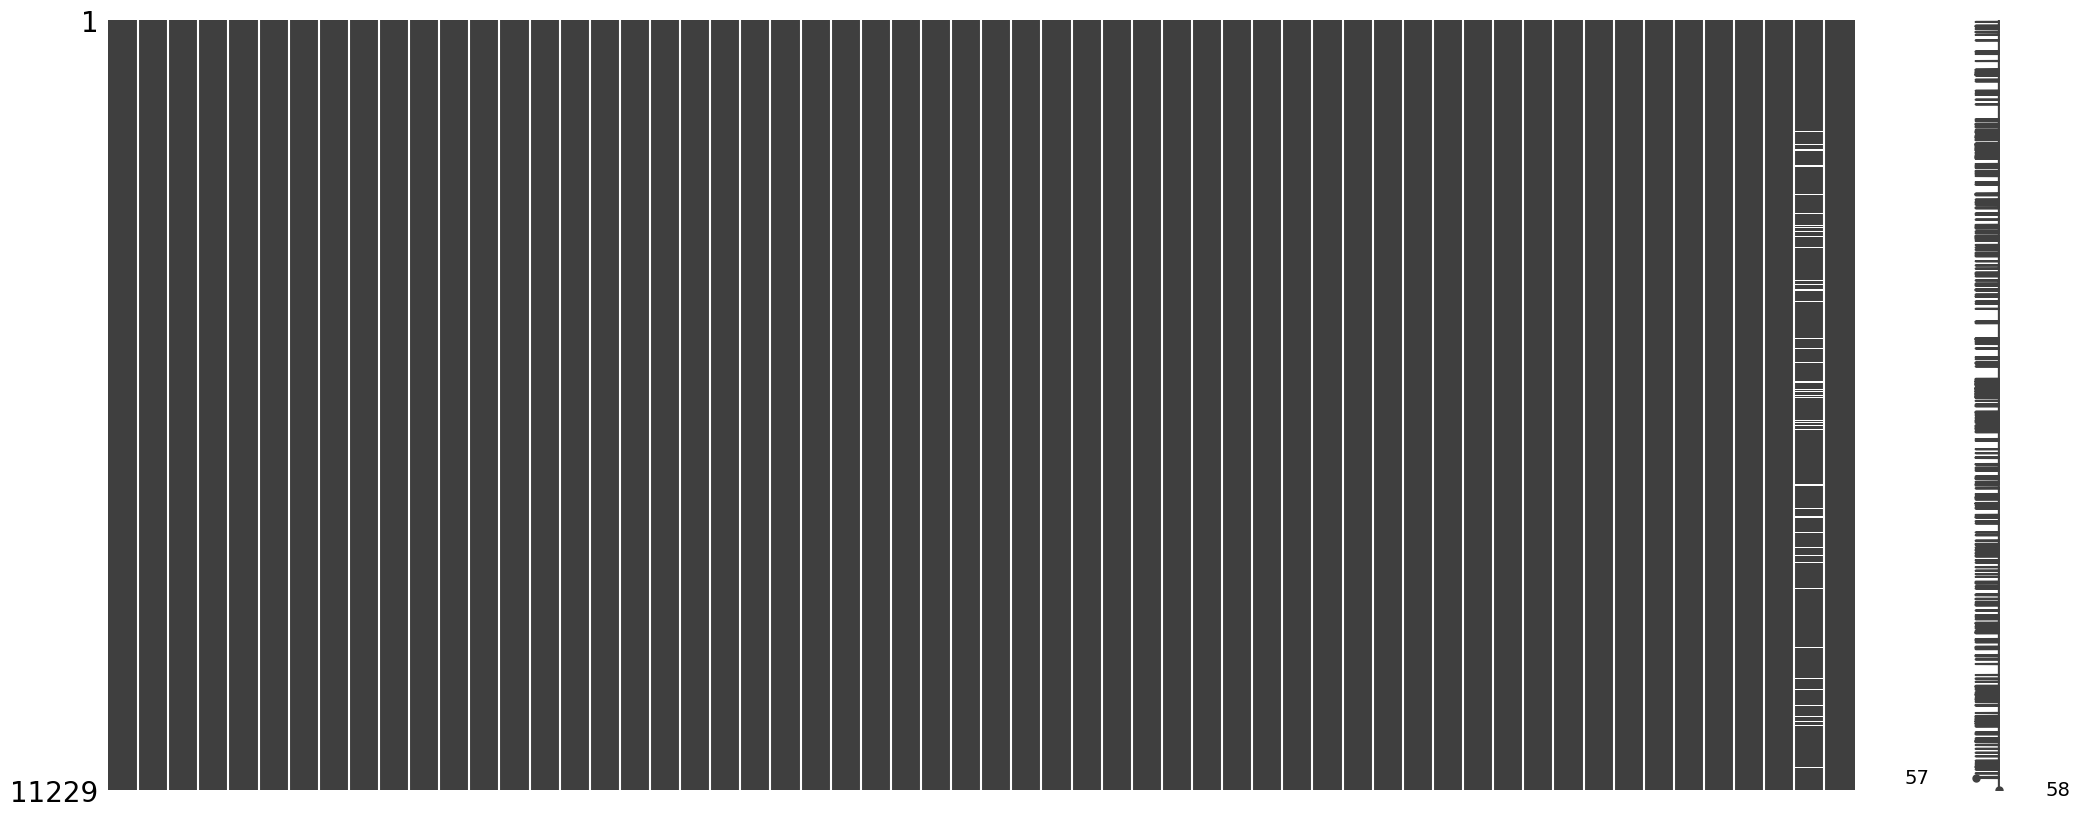

In [32]:
msno.matrix(df)

### UHI Index

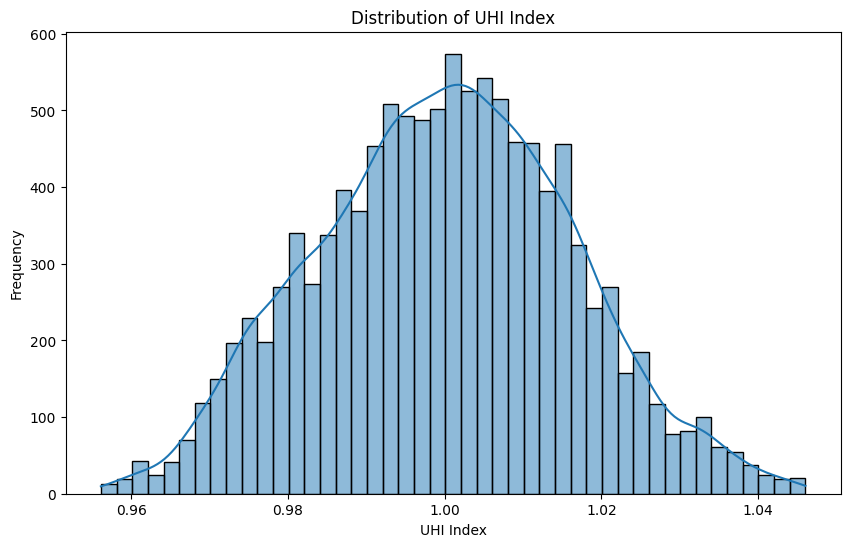

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df['UHI Index'], bins='auto', kde=True)
plt.title('Distribution of UHI Index')
plt.xlabel('UHI Index')
plt.ylabel('Frequency')
plt.show()

### Bla blaa

## Data Preprocesing

In [33]:
uhi_data = df.drop(columns=(['Longitude', 'Latitude', 'datetime'] + excluded_feautures))
uhi_data

UHI Index       red      blue     green     nir08    swir16    swir22  \
0       1.030289  0.071398  0.045602  0.069528  0.208870  0.136490  0.095432   
1       1.030289  0.071398  0.045602  0.069528  0.208870  0.136490  0.095432   
2       1.023798  0.107835  0.088750  0.106762  0.230017  0.185000  0.135252   
3       1.023798  0.107835  0.088750  0.106762  0.230017  0.185000  0.135252   
4       1.021634  0.107835  0.088750  0.106762  0.230017  0.185000  0.135252   
...          ...       ...       ...       ...       ...       ...       ...   
11224   0.972470  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
11225   0.972470  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
11226   0.981124  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
11227   0.981245  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
11228   0.983408  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   

        coastal     lwir11  building_height  ...   awei_sh      ndsi  \
0      0.039250  37.785534        65.099998  ...  0.232418 -0.325033   
1      0.039250  37.785534        65.099998  ...  0.232418 -0.325033   
2      0.075742  37.358281         0.000000  ...  0.179240 -0.268155   
3      0.075742  37.358281         0.000000  ...  0.179240 -0.268155   
4      0.075742  37.358281         0.000000  ...  0.179240 -0.268155   
...         ...        ...              ...  ...       ...       ...   
11224  0.048627  30.440209         0.000000  ...  0.473263 -0.413842   
11225  0.048627  30.440209         0.000000  ...  0.473263 -0.413842   
11226  0.048627  30.440209         0.000000  ...  0.473263 -0.413842   
11227  0.048627  30.440209         0.000000  ...  0.473263 -0.413842   
11228  0.048627  30.440209         0.000000  ...  0.473263 -0.413842   

            nbr        si      ndbi        ui       ibi    albedo       VAR  \
0      0.372779  0.499128 -0.209578  0.313114  0.550527  0.102261  1.479545   
1      0.372779  0.499128 -0.209578  0.313114  0.550527  0.102261  1.479545   
2      0.259438  0.351598 -0.108471  0.263510  0.374065  0.136686  0.000000   
3      0.259438  0.351598 -0.108471  0.263510  0.374065  0.136686  0.000000   
4      0.259438  0.351598 -0.108471  0.263510  0.374065  0.136686  0.000000   
...         ...       ...       ...       ...       ...       ...       ...   
11224  0.524984  0.561994 -0.296239  0.476156  1.298300  0.154906  0.000000   
11225  0.524984  0.561994 -0.296239  0.476156  1.298300  0.154906  0.000000   
11226  0.524984  0.561994 -0.296239  0.476156  1.298300  0.154906  0.000000   
11227  0.524984  0.561994 -0.296239  0.476156  1.298300  0.154906  0.000000   
11228  0.524984  0.561994 -0.296239  0.476156  1.298300  0.154906  0.000000   

       Building_area_per_pixel  
0                      0.09663  
1                      0.09663  
2                      0.00000  
3                      0.00000  
4                      0.00000  
...                        ...  
11224                  0.00000  
11225                  0.00000  
11226                  0.00000  
11227                  0.00000  
11228                  0.00000  

[11229 rows x 55 columns]

### Missing values

In [34]:
# uhi_data['VAR'].fillna(uhi_data['VAR'].mean(), inplace=True)
uhi_data['VAR'].fillna(1000, inplace=True)
# uhi_data['Interpolated_PM10'].fillna(16.84375, inplace=True)
# uhi_data.drop(columns=['Interpolated_PM10'], inplace=True)

In [35]:
uhi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 55 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   UHI Index                                11229 non-null  float64 
 1   red                                      11229 non-null  float64 
 2   blue                                     11229 non-null  float64 
 3   green                                    11229 non-null  float64 
 4   nir08                                    11229 non-null  float64 
 5   swir16                                   11229 non-null  float64 
 6   swir22                                   11229 non-null  float64 
 7   coastal                                  11229 non-null  float64 
 8   lwir11                                   11229 non-null  float64 
 9   building_height                          11229 non-null  float64 
 10  building_sd                       

### Removing duplicates

In [36]:
# Check the duplicated records
print(f'Duplicated Rows: {uhi_data.duplicated().sum()}')

Duplicated Rows: 3615


In [37]:
uhi_data.columns

Index(['UHI Index', 'red', 'blue', 'green', 'nir08', 'swir16', 'swir22',
       'coastal', 'lwir11', 'building_height', 'building_sd', 'building_year',
       'building_area', 'street_width', 'street_traffic', 'street_lane',
       'street_orientation', 'CO_column_number_density',
       'tropospheric_HCHO_column_number_density',
       'HCHO_slant_column_number_density', 'NO2_column_number_density',
       'tropospheric_NO2_column_number_density',
       'stratospheric_NO2_column_number_density',
       'NO2_slant_column_number_density', 'O3_column_number_density',
       'O3_slant_column_number_density', 'SO2_column_number_density',
       'SO2_slant_column_number_density', 'Optical_Depth_047',
       'Optical_Depth_055', 'AOD_Uncertainty', 'FineModeFraction', 'Column_WV',
       'Injection_Height', 'AOD_QA', 'AngstromExp_470-780', 'ndvi', 'evi',
       'savi', 'gndvi', 'arvi', 'msavi', 'ndwi', 'mndwi', 'awei_nsh',
       'awei_sh', 'ndsi', 'nbr', 'si', 'ndbi', 'ui', 'ibi', 'albedo',

In [38]:
# # Remove duplicate rows from the DataFrame based on specified columns and keep the first occurrence
# columns = ['lwir11', 'building_height', 'building_year', 'ndvi', 'ndbi', 'ndwi', 'street_width', 'building_area']
# for col in columns:
#     # Check if the value is a numpy array and has more than one dimension
#     uhi_data[col] = uhi_data[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# # Now remove duplicates
uhi_data = uhi_data.drop_duplicates(keep='first')
uhi_data


UHI Index       red      blue     green     nir08    swir16    swir22  \
0       1.030289  0.071398  0.045602  0.069528  0.208870  0.136490  0.095432   
2       1.023798  0.107835  0.088750  0.106762  0.230017  0.185000  0.135252   
4       1.021634  0.107835  0.088750  0.106762  0.230017  0.185000  0.135252   
6       1.015143  0.182663  0.112262  0.159618  0.245830  0.226635  0.187200   
8       1.012979  0.182663  0.112262  0.159618  0.245830  0.226635  0.187200   
...          ...       ...       ...       ...       ...       ...       ...   
11220   0.976797  0.048765  0.043843  0.066503  0.356765  0.188905  0.100052   
11223   0.972470  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
11226   0.981124  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
11227   0.981245  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
11228   0.983408  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   

        coastal     lwir11  building_height  ...   awei_sh      ndsi  \
0      0.039250  37.785534        65.099998  ...  0.232418 -0.325033   
2      0.075742  37.358281         0.000000  ...  0.179240 -0.268155   
4      0.075742  37.358281         0.000000  ...  0.179240 -0.268155   
6      0.092710  37.091675        12.830000  ...  0.125374 -0.173507   
8      0.092710  37.091675        12.830000  ...  0.125374 -0.173507   
...         ...        ...              ...  ...       ...       ...   
11220  0.040955  30.293234         0.000000  ...  0.514018 -0.479244   
11223  0.048627  30.440209         0.000000  ...  0.473263 -0.413842   
11226  0.048627  30.440209         0.000000  ...  0.473263 -0.413842   
11227  0.048627  30.440209         0.000000  ...  0.473263 -0.413842   
11228  0.048627  30.440209         0.000000  ...  0.473263 -0.413842   

            nbr        si      ndbi        ui       ibi    albedo       VAR  \
0      0.372779  0.499128 -0.209578  0.313114  0.550527  0.102261  1.479545   
2      0.259438  0.351598 -0.108471  0.263510  0.374065  0.136686  0.000000   
4      0.259438  0.351598 -0.108471  0.263510  0.374065  0.136686  0.000000   
6      0.135395  0.337484 -0.040627  0.107434 -0.275067  0.167469  0.356389   
8      0.135395  0.337484 -0.040627  0.107434 -0.275067  0.167469  0.356389   
...         ...       ...       ...       ...       ...       ...       ...   
11220  0.561959  0.623261 -0.307622  0.589641  1.223767  0.157757  0.000000   
11223  0.524984  0.561994 -0.296239  0.476156  1.298300  0.154906  0.000000   
11226  0.524984  0.561994 -0.296239  0.476156  1.298300  0.154906  0.000000   
11227  0.524984  0.561994 -0.296239  0.476156  1.298300  0.154906  0.000000   
11228  0.524984  0.561994 -0.296239  0.476156  1.298300  0.154906  0.000000   

       Building_area_per_pixel  
0                     0.096630  
2                     0.000000  
4                     0.000000  
6                     0.003479  
8                     0.003479  
...                        ...  
11220                 0.000000  
11223                 0.000000  
11226                 0.000000  
11227                 0.000000  
11228                 0.000000  

[7614 rows x 55 columns]

In [39]:
# Resetting the index of the dataset
uhi_data = uhi_data.reset_index(drop=True)

### Encoding

In [40]:
# One-hot encodiing
uhi_data = pd.get_dummies(data=uhi_data, columns=categorical_cols)
uhi_data

UHI Index       red      blue     green     nir08    swir16    swir22  \
0      1.030289  0.071398  0.045602  0.069528  0.208870  0.136490  0.095432   
1      1.023798  0.107835  0.088750  0.106762  0.230017  0.185000  0.135252   
2      1.021634  0.107835  0.088750  0.106762  0.230017  0.185000  0.135252   
3      1.015143  0.182663  0.112262  0.159618  0.245830  0.226635  0.187200   
4      1.012979  0.182663  0.112262  0.159618  0.245830  0.226635  0.187200   
...         ...       ...       ...       ...       ...       ...       ...   
7609   0.976797  0.048765  0.043843  0.066503  0.356765  0.188905  0.100052   
7610   0.972470  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
7611   0.981124  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
7612   0.981245  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
7613   0.983408  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   

       coastal     lwir11  building_height  ...  street_traffic_-1.0  \
0     0.039250  37.785534        65.099998  ...                False   
1     0.075742  37.358281         0.000000  ...                False   
2     0.075742  37.358281         0.000000  ...                False   
3     0.092710  37.091675        12.830000  ...                False   
4     0.092710  37.091675        12.830000  ...                False   
...        ...        ...              ...  ...                  ...   
7609  0.040955  30.293234         0.000000  ...                False   
7610  0.048627  30.440209         0.000000  ...                False   
7611  0.048627  30.440209         0.000000  ...                False   
7612  0.048627  30.440209         0.000000  ...                False   
7613  0.048627  30.440209         0.000000  ...                False   

      street_traffic_1.0  street_traffic_2.0  street_traffic_3.0  \
0                  False               False               False   
1                   True               False               False   
2                   True               False               False   
3                   True               False               False   
4                   True               False               False   
...                  ...                 ...                 ...   
7609               False               False               False   
7610               False               False               False   
7611               False               False               False   
7612               False               False               False   
7613               False               False               False   

      street_traffic_4.0  street_orientation_-1.0  street_orientation_0.0  \
0                   True                    False                   False   
1                  False                    False                   False   
2                  False                    False                   False   
3                  False                    False                   False   
4                  False                    False                   False   
...                  ...                      ...                     ...   
7609                True                    False                   False   
7610                True                    False                   False   
7611                True                    False                   False   
7612                True                    False                   False   
7613                True                    False                   False   

      street_orientation_1.0  street_orientation_2.0  street_orientation_3.0  
0                       True                   False                   False  
1                       True                   False                   False  
2                       True                   False                   False  
3                       True                   False                   False  
4                       True                   False   

## Model Building

In [41]:
flag = 1
if flag == 1:   
    # pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
else:
    pd.reset_option('display.max_rows', None)
    pd.reset_option('display.max_columns', None)
uhi_data

UHI Index       red      blue     green     nir08    swir16    swir22  \
0      1.030289  0.071398  0.045602  0.069528  0.208870  0.136490  0.095432   
1      1.023798  0.107835  0.088750  0.106762  0.230017  0.185000  0.135252   
2      1.021634  0.107835  0.088750  0.106762  0.230017  0.185000  0.135252   
3      1.015143  0.182663  0.112262  0.159618  0.245830  0.226635  0.187200   
4      1.012979  0.182663  0.112262  0.159618  0.245830  0.226635  0.187200   
...         ...       ...       ...       ...       ...       ...       ...   
7609   0.976797  0.048765  0.043843  0.066503  0.356765  0.188905  0.100052   
7610   0.972470  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
7611   0.981124  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
7612   0.981245  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
7613   0.983408  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   

       coastal     lwir11  building_height  building_sd  building_year  \
0     0.039250  37.785534        65.099998          0.0         1928.0   
1     0.075742  37.358281         0.000000         -1.0            0.0   
2     0.075742  37.358281         0.000000         -1.0            0.0   
3     0.092710  37.091675        12.830000          0.0         1931.0   
4     0.092710  37.091675        12.830000          0.0         1931.0   
...        ...        ...              ...          ...            ...   
7609  0.040955  30.293234         0.000000         -1.0            0.0   
7610  0.048627  30.440209         0.000000         -1.0            0.0   
7611  0.048627  30.440209         0.000000         -1.0            0.0   
7612  0.048627  30.440209         0.000000         -1.0            0.0   
7613  0.048627  30.440209         0.000000         -1.0            0.0   

      building_area  street_width  street_lane  CO_column_number_density  \
0        936.111511          44.0     4.000000                  0.038713   
1          0.000000          31.0     2.333333                  0.038713   
2          0.000000          31.0     2.333333                  0.038713   
3         33.707344          36.0     3.000000                  0.038713   
4         33.707344          36.0     3.000000                  0.038713   
...             ...           ...          ...                       ...   
7609       0.000000          43.0     1.000000                  0.040459   
7610       0.000000          37.5     1.000000                  0.040459   
7611       0.000000          37.5     1.000000                  0.040459   
7612       0.000000          37.5     1.000000                  0.040459   
7613       0.000000          37.5     1.000000                  0.040459   

      tropospheric_HCHO_column_number_density  \
0                                    0.000226   
1                                    0.000226   
2                                    0.000226   
3                                    0.000226   
4                                    0.000226   
...                                       ...   
7609                                 0.000227   
7610                                 0.000227   
7611                                 0.000227   
7612                                 0.000227   
7613                                 0.000227   

      HCHO_slant_column_number_density  NO2_column_number_density  \
0                             0.000157                   0.000204   
1                             0.000157                   0.000204   
2                             0.000157                   0.000204   
3                             0.000157                   0.000204   
4                             0.000157                   0.000204   
...                                ...                        ...   
7609                          0.000147                   0.000203   
7610                          0.000147                   0.000203   
7611                          0.000147       

### Train and Test Split 

<p align="justify">We will now split the data into 70% training data and 30% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

In [42]:
# Split the data into features (X) and target (y), and then into training and testing sets
# columns = uhi_data.drop(columns=['UHI Index']).columns
# X = uhi_data[columns].values
X = uhi_data.drop(columns=['UHI Index'])
y = uhi_data['UHI Index']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

### Feature Scaling 

In [43]:
# Scale the training and test data using standardscaler
sc = StandardScaler()
X_train[numerical_cols] = sc.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = sc.transform(X_test[numerical_cols])

<Axes: >

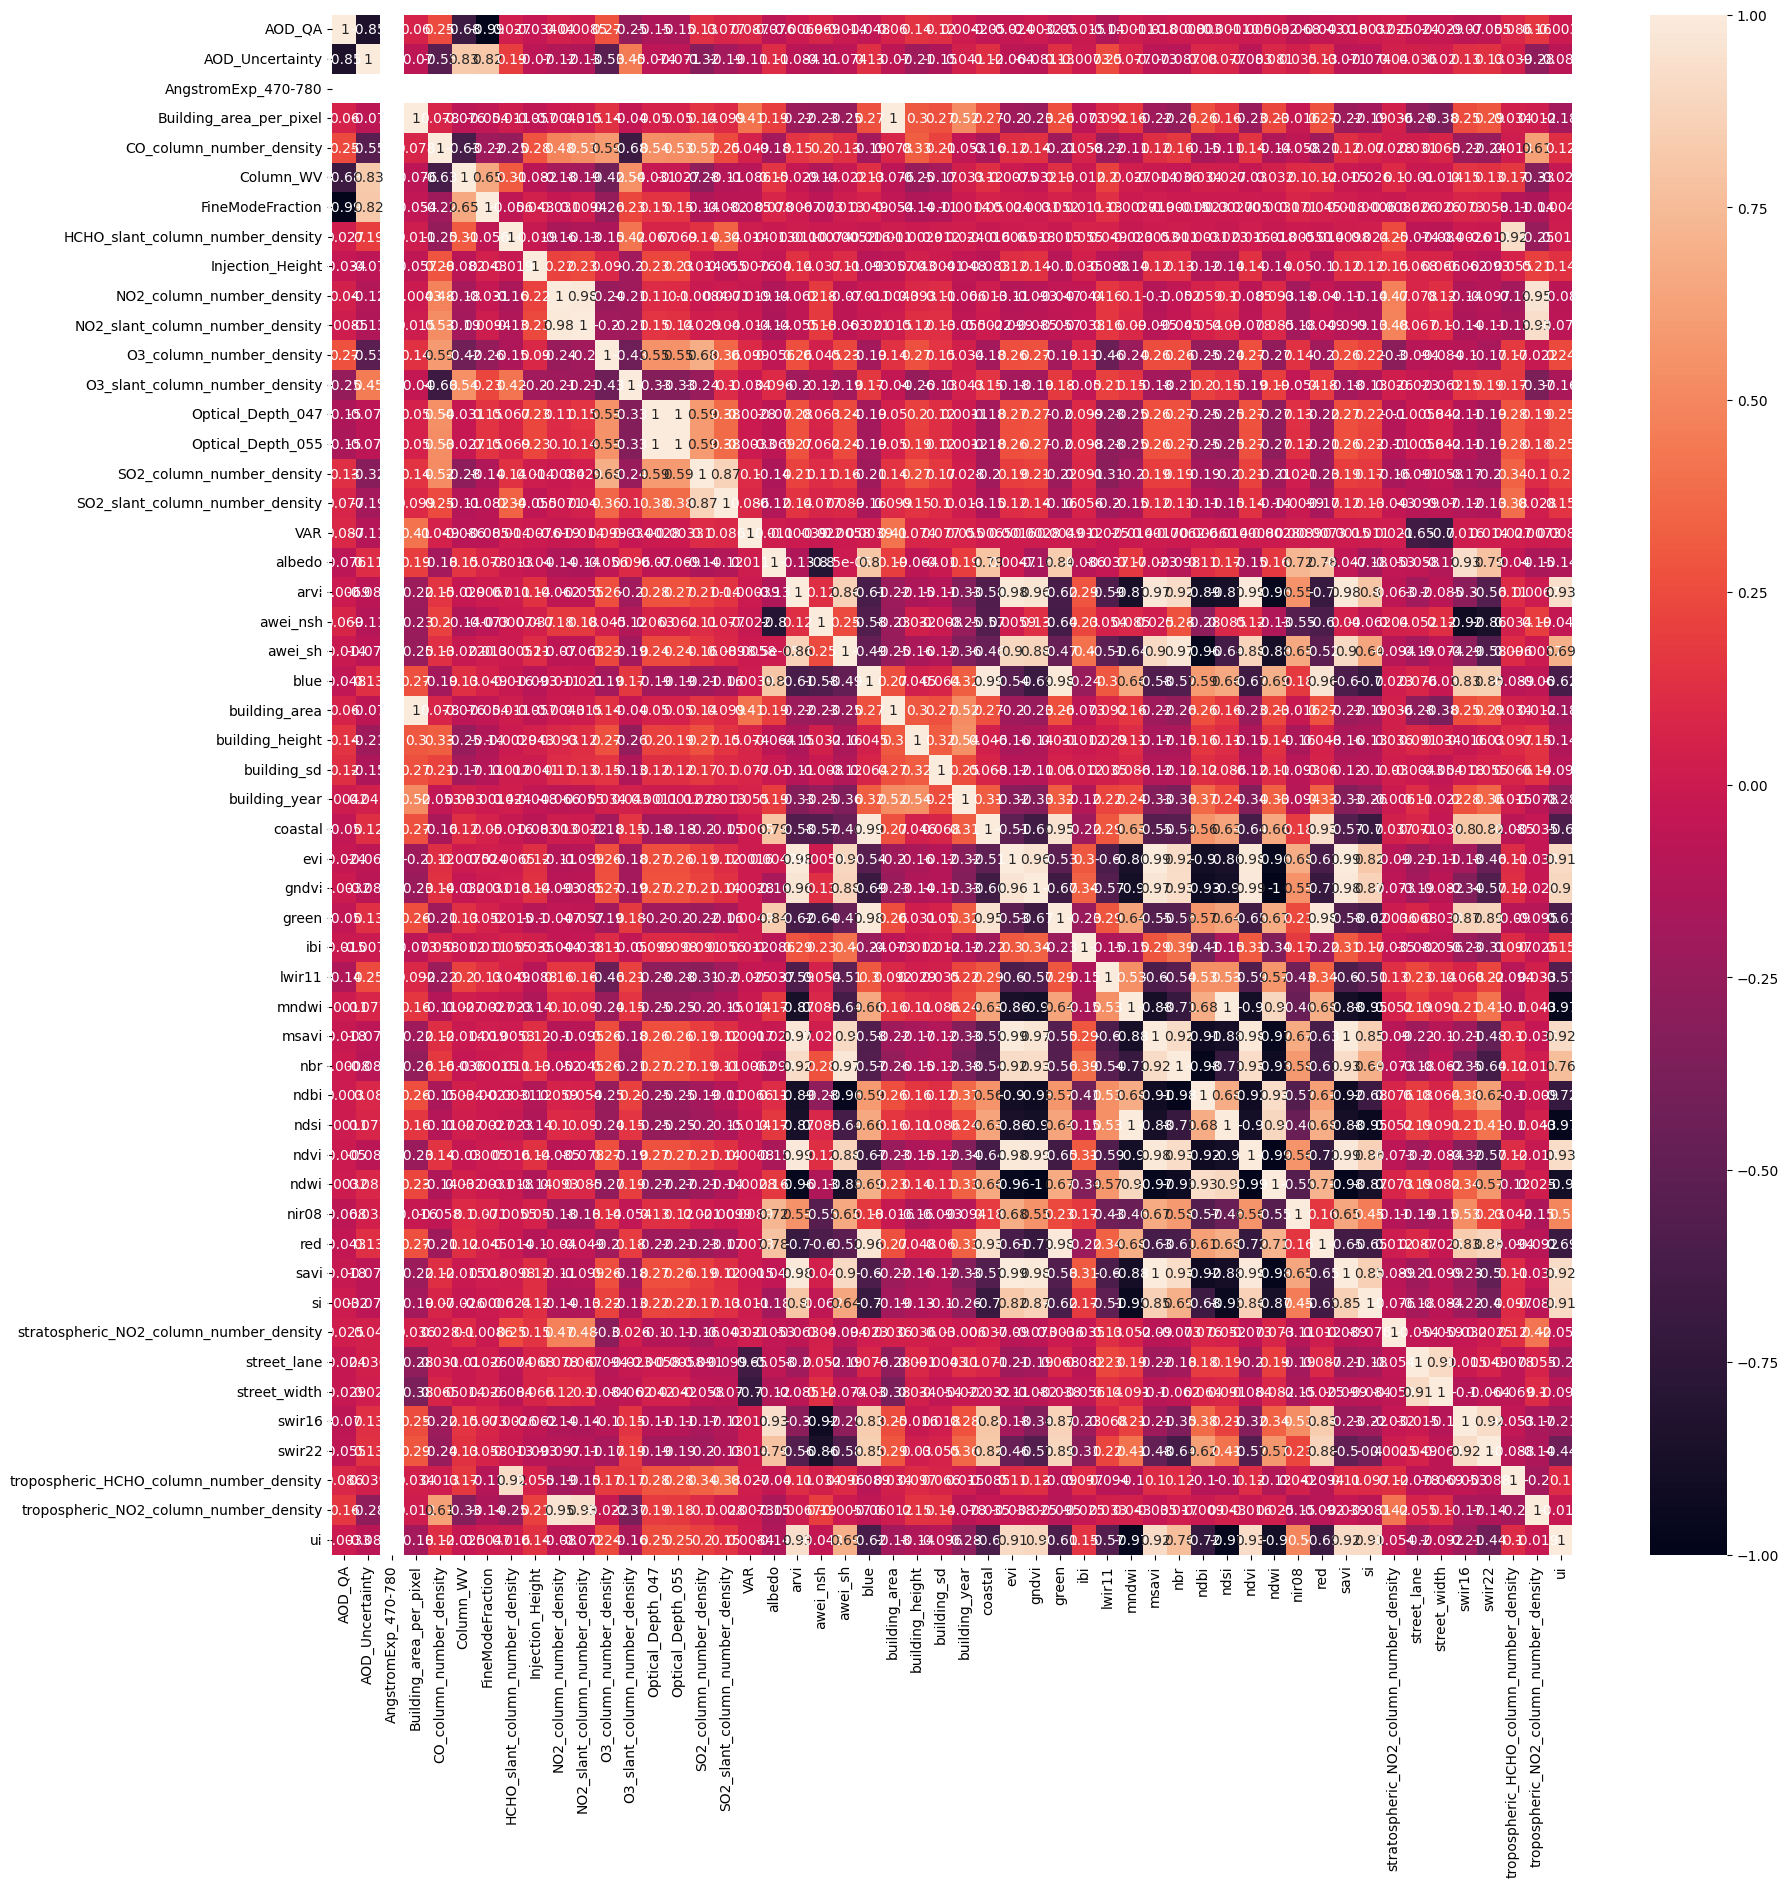

In [44]:
feat_corr = uhi_data[numerical_cols].corr()
plt.figure(figsize=(20, 20))
sns.heatmap(feat_corr, annot=True)

### Model Training

In [45]:
X_train

red      blue     green     nir08    swir16    swir22   coastal  \
1186 -1.560502 -1.419353 -1.497283  0.223497 -1.420812 -1.555394 -1.418069   
6727  1.020357  0.994225  0.922054  0.957993  0.852599  0.895324  1.149626   
5462 -0.317196 -0.320093 -0.396635 -1.316787 -0.964827 -0.517270 -0.289705   
6334 -0.201118 -0.537149 -0.230187  0.093107 -0.240679 -0.249791 -0.651018   
7446 -1.434308 -1.391389 -1.357246  1.232842 -0.649437 -1.152156 -1.317375   
...        ...       ...       ...       ...       ...       ...       ...   
5226  0.515047  0.106694  0.556604  0.352948  0.401500  0.100960  0.103446   
5390 -0.470013 -0.388672 -0.522547 -1.593513 -0.801975 -0.287642 -0.574757   
860  -1.579671 -1.544526 -1.455518  1.457506 -0.657580 -1.468084 -1.449906   
7603 -1.991799 -1.862120 -1.758319  2.264232 -0.777547 -1.629077 -1.759392   
7270  0.277568  0.239191  0.132806 -0.681256 -0.031686  0.123166  0.070868   

        lwir11  building_height  building_sd  building_year  building_area  \
1186 -1.430174        -0.798711    -0.372298      -1.503813      -0.781908   
6727 -0.514162         0.136559    -0.320076       0.667773       2.955423   
5462  1.350078        -0.798711    -0.372298      -1.503813      -0.781908   
6334  0.592337         0.590823     0.822284       0.687901       0.565602   
7446 -0.581392        -0.798711    -0.372298      -1.503813      -0.781908   
...        ...              ...          ...            ...            ...   
5226  1.270242        -0.798711    -0.372298      -1.503813      -0.781908   
5390  4.327818        -0.522756    -0.320076       0.655473      -0.665042   
860  -2.297164        -0.798711    -0.372298      -1.503813      -0.781908   
7603 -2.711751        -0.798711    -0.372298      -1.503813      -0.781908   
7270  0.672173        -0.798711    -0.372298      -1.503813      -0.781908   

      street_width  street_lane  CO_column_number_density  \
1186      0.320091     0.328684                  1.554025   
6727     -2.364203    -2.221100                 -0.937189   
5462      0.229609     0.009961                 -1.166224   
6334      1.255070     1.603575                  0.391618   
7446     -2.364203    -2.221100                  0.713388   
...            ...          ...                       ...   
5226     -0.252960     0.328684                 -1.003541   
5390      1.255070     0.328684                  0.186131   
860      -0.051890    -0.308762                  0.857685   
7603     -0.102157    -1.583654                  1.016852   
7270      1.261102     1.603575                  0.124703   

      tropospheric_HCHO_column_number_density  \
1186                                 0.826836   
6727                                -0.397950   
5462                                -1.169254   
6334                                 0.176392   
7446                                -0.689673   
...                                       ...   
5226                                -1.410976   
5390                                -1.301674   
860                                  0.123556   
7603                                -0.476858   
7270                                -0.735346   

      HCHO_slant_column_number_density  NO2_column_number_density  \
1186                          0.258005                   0.880510   
6727                         -0.351393                  -3.435917   
5462                         -0.526315                   0.774916   
6334                         -0.253625                   0.645292   
7446                         -1.034246                  -0.824019   
...                                ...                        ...   
5226                         -0.909473                   0.889620   
5390                         -0.731817                   0.813545   
860                           0.161152                   0.230426   
7603                         -0.809009                   0.417852   
7270                         -0.946605                  

#### Random Forest

In [40]:
# Random Forest 
# rf = RandomForestRegressor(random_state=42)

In [41]:
# rf_param_grid = {
#     "n_estimators":[100, 200, 300],
#     "max_depth": [3, 5, 7, 9],
#     "min_samples_split": [2, 5, 7], 
#     "min_samples_leaf": [1, 2, 4],    
#     "criterion": ['squared_error'],
# }

# rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=5, n_jobs=-1, verbose=2, scoring='r2')
# rf_grid_search.fit(X_train, y_train)

In [42]:
# print("RF Best Parameters:", rf_grid_search.best_params_)
# print("RF Best Score:", rf_grid_search.best_score_)

In [43]:
# rf_best_params = RandomForestRegressor(
#     n_estimators=200,
#     criterion='squared_error',
#     max_depth=10,
#     min_samples_leaf=5,
#     min_samples_split=5,
#     # **rf_grid_search.best_params_,
#     random_state=42
# )
# rf.fit(X_train, y_train)

##### In-Sample Evaluation

In [44]:
# # Perform Cross-validation
# rf_cv_scores = cross_val_score(
#     estimator=rf,
#     X=X_train,
#     y=y_train,
#     cv=KFold(10),
#     scoring='r2'
# )


In [45]:
# print("Cross-validation scores:", rf_cv_scores)
# print("Mean R² score:", np.mean(rf_cv_scores))
# print("Standard Deviation", np.std(rf_cv_scores))

In [46]:
# Make predictions on the training data
# insample_predictions = rf.predict(X_train)

In [47]:
# calculate R-squared score for in-sample predictions
# Y_train = y_train.tolist()
# r2_score(Y_train, insample_predictions)

##### Out-Sample Evaluation

In [48]:
# Make predictions on the test data
# outsample_predictions = rf.predict(X_test)

In [49]:
# calculate R-squared score for out-sample predictions
# Y_test = y_test.tolist()
# r2_score(Y_test, outsample_predictions)

#### XGBoost

In [46]:
# Xtreme Gradient Boosting
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,
    min_child_weight=5,
    colsample_bytree=1,
    subsample=0.8,
    random_state=42
)

In [51]:
# xgb_param_grid = {
#     'n_estimators': [100],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.001, 0.01, 0.1],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=5, n_jobs=-1, verbose=2, scoring='r2')
# xgb_grid_search.fit(X_train, y_train)

In [52]:
# print("XGB Best Parameters:", xgb_grid_search.best_params_)
# print("XGB Best Score:", xgb_grid_search.best_score_)

In [47]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, random_state=42, ...)

##### In-Sample Evaluation

In [73]:
# Perform Cross-Validation 
xgb_cv_scores = cross_val_score(
    estimator=xgb,
    X=X_train,
    y=y_train,
    cv=KFold(10),
    scoring='r2'
)

In [74]:
print("Cross-validation scores:", xgb_cv_scores)
print("Mean R² score:", np.mean(xgb_cv_scores))
print("Standard Deviation", np.std(xgb_cv_scores))

Cross-validation scores: [0.84898455 0.86063235 0.86302786 0.86162125 0.85600104 0.81663879
 0.85161948 0.84971082 0.85470911 0.86410977]
Mean R² score: 0.8527055029214219
Standard Deviation 0.013109576411581158


In [48]:
# Make predictions on the training data
insample_predictions = xgb.predict(X_train)

In [49]:
# calculate R-squared score for in-sample predictions
Y_train = y_train.tolist()
r2_score(Y_train, insample_predictions)

0.9896827863266237

##### Out-Sample Evaluation

In [50]:
# Make predictions on the test data
outsample_predictions = xgb.predict(X_test)

In [51]:
# calculate R-squared score for out-sample predictions
Y_test = y_test.tolist()
r2_score(Y_test, outsample_predictions)

0.8676240073573981

##### Residuals

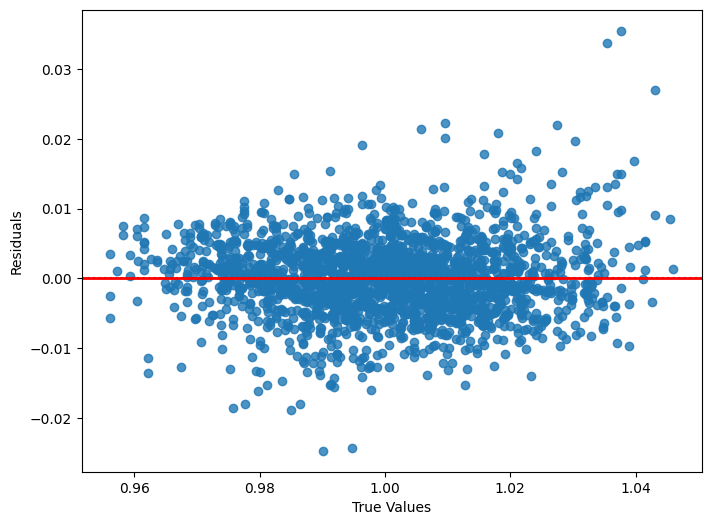

In [52]:
residuals = Y_test - outsample_predictions

plt.figure(figsize=(8, 6))
sns.residplot(x=Y_test, y=residuals, line_kws={"color": "red", "lw": 2})
plt.axhline(0, color='red', linewidth=2)
plt.xlabel("True Values")
plt.ylabel("Residuals")
plt.show()

##### Features Importance

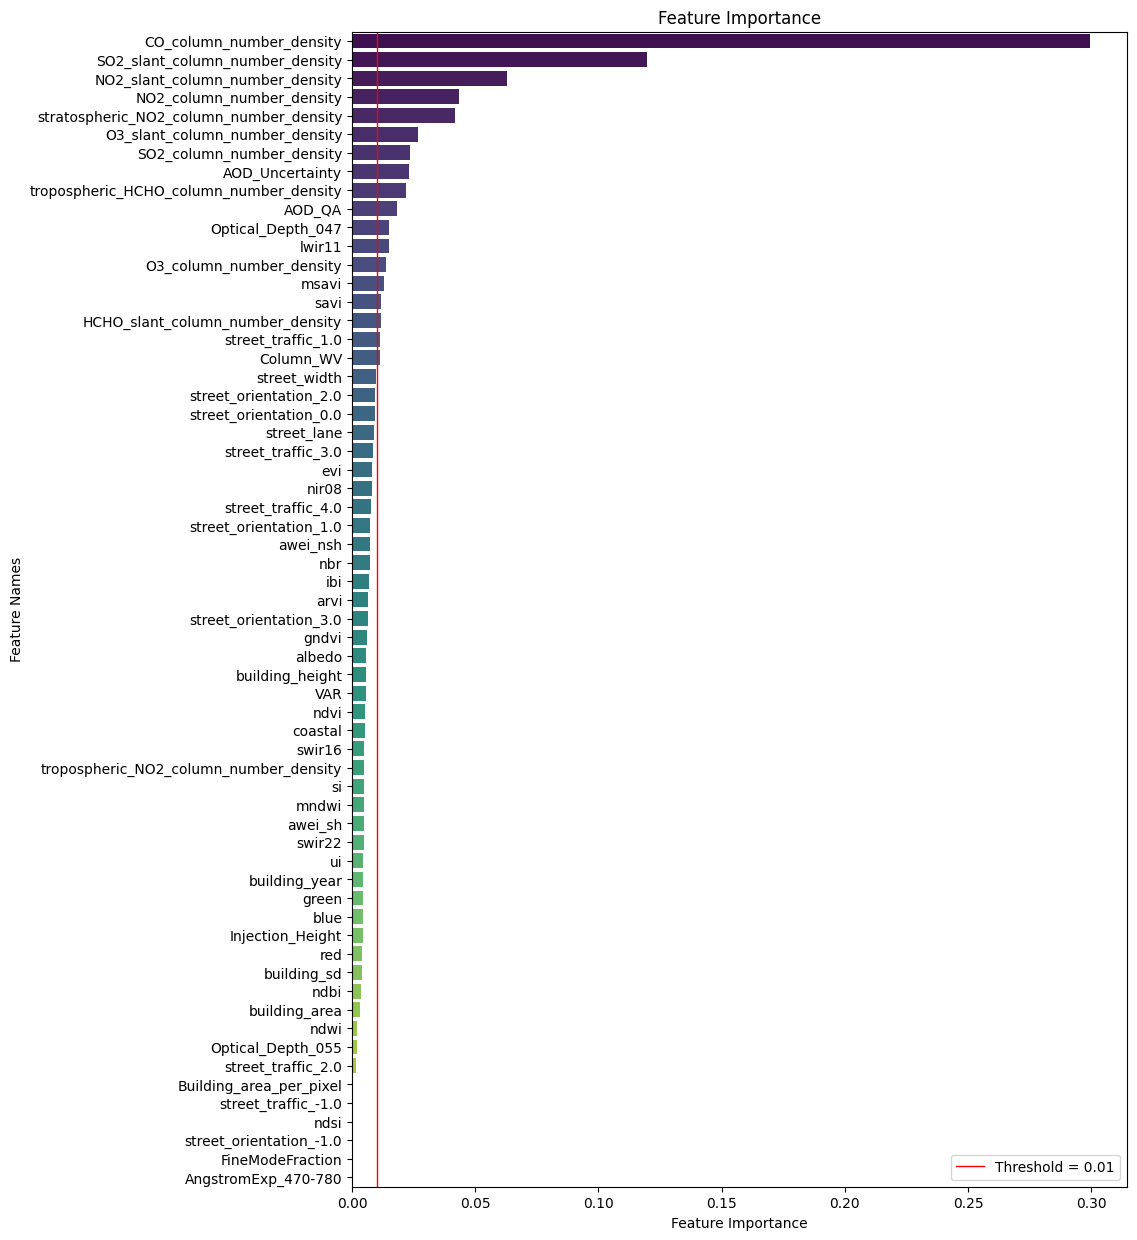

In [53]:
feature_importances = xgb.feature_importances_

feature_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_df = feature_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 15))
sns.barplot(x="Importance", y="Feature", data=feature_df, palette="viridis")
plt.axvline(x=0.01, color='red', linestyle='-', linewidth=1, label="Threshold = 0.01")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("Feature Importance")
plt.legend()
plt.show()

In [256]:
threshold = 0.01

important_features = feature_df[feature_df["Importance"] > threshold]
print(important_features)

                   Feature  Importance
8                      SO2    0.194113
14       Optical_Depth_047    0.114627
15         AOD_Uncertainty    0.086290
12                     VOC    0.079160
10                      O3    0.075053
16               Column_WV    0.073889
7                       CO    0.039047
11                    PM25    0.035828
13                      NO    0.032563
9                      NO2    0.030675
30      street_traffic_1.0    0.021318
6              street_lane    0.020339
18                  AOD_QA    0.015984
3                   lwir11    0.013729
37  street_orientation_2.0    0.012337
36  street_orientation_1.0    0.012082
5             street_width    0.011872


#### CatBoost


In [120]:
cb = CatBoostRegressor(n_estimators=100, random_state=42)

In [121]:
cb.fit(X_train, y_train)

Learning rate set to 0.352161
0:	learn: 0.0138341	total: 178ms	remaining: 17.6s
1:	learn: 0.0123312	total: 186ms	remaining: 9.13s
2:	learn: 0.0114314	total: 198ms	remaining: 6.39s
3:	learn: 0.0107559	total: 206ms	remaining: 4.93s
4:	learn: 0.0104155	total: 214ms	remaining: 4.06s
5:	learn: 0.0101732	total: 221ms	remaining: 3.46s
6:	learn: 0.0098690	total: 233ms	remaining: 3.09s
7:	learn: 0.0096805	total: 242ms	remaining: 2.79s
8:	learn: 0.0094678	total: 250ms	remaining: 2.53s
9:	learn: 0.0093554	total: 264ms	remaining: 2.38s
10:	learn: 0.0091659	total: 273ms	remaining: 2.21s
11:	learn: 0.0090178	total: 282ms	remaining: 2.06s
12:	learn: 0.0089042	total: 291ms	remaining: 1.95s
13:	learn: 0.0088052	total: 299ms	remaining: 1.83s
14:	learn: 0.0087353	total: 307ms	remaining: 1.74s
15:	learn: 0.0087028	total: 315ms	remaining: 1.65s
16:	learn: 0.0085909	total: 322ms	remaining: 1.57s
17:	learn: 0.0084599	total: 328ms	remaining: 1.5s
18:	learn: 0.0083786	total: 336ms	remaining: 1.43s
19:	learn: 0

##### In-Sample Evaluation

In [342]:
# Perform Cross-Validation 
cb_cv_scores = cross_val_score(
    estimator=cb,
    X=X_train,
    y=y_train,
    cv=KFold(10),
    scoring='r2'
)

Learning rate set to 0.340992
0:	learn: 0.0140018	total: 44.6ms	remaining: 4.41s
1:	learn: 0.0125479	total: 55.5ms	remaining: 2.72s
2:	learn: 0.0116543	total: 62.4ms	remaining: 2.02s
3:	learn: 0.0111683	total: 70.1ms	remaining: 1.68s
4:	learn: 0.0109052	total: 77.4ms	remaining: 1.47s
5:	learn: 0.0106799	total: 83.8ms	remaining: 1.31s
6:	learn: 0.0104381	total: 90.3ms	remaining: 1.2s
7:	learn: 0.0102365	total: 96.8ms	remaining: 1.11s
8:	learn: 0.0101260	total: 103ms	remaining: 1.04s
9:	learn: 0.0100029	total: 127ms	remaining: 1.14s
10:	learn: 0.0099323	total: 133ms	remaining: 1.07s
11:	learn: 0.0098875	total: 139ms	remaining: 1.02s
12:	learn: 0.0098391	total: 145ms	remaining: 971ms
13:	learn: 0.0097277	total: 152ms	remaining: 931ms
14:	learn: 0.0096628	total: 159ms	remaining: 901ms
15:	learn: 0.0095942	total: 165ms	remaining: 865ms
16:	learn: 0.0095282	total: 173ms	remaining: 846ms
17:	learn: 0.0094640	total: 181ms	remaining: 825ms
18:	learn: 0.0093860	total: 187ms	remaining: 798ms
19:	

In [65]:
print("Cross-validation scores:", cb_cv_scores)
print("Mean R² score:", np.mean(cb_cv_scores))
print("Standard Deviation", np.std(cb_cv_scores))

Cross-validation scores: [0.8378577  0.84281124 0.81350826 0.82113416 0.81229642 0.86067286
 0.85594796 0.83061629 0.8318416  0.81565042]
Mean R² score: 0.8322336906511583
Standard Deviation 0.01632108243433861


In [66]:
# Make predictions on the training data
insample_predictions = cb.predict(X_train)

In [67]:
# calculate R-squared score for in-sample predictions
Y_train = y_train.tolist()
r2_score(Y_train, insample_predictions)

0.9074306024953814

##### Out-Sample Evaluation

In [68]:
# Make predictions on the test data
outsample_predictions = cb.predict(X_test)

In [69]:
# calculate R-squared score for out-sample predictions
Y_test = y_test.tolist()
r2_score(Y_test, outsample_predictions)

0.8469565860087491

#### Save Model

In [70]:
# import joblib

# RF_SAVE_DIR = 'models/RandomForest/'
# XGB_SAVE_DIR = 'models/XGB/'
# CB_SAVE_DIR = 'models/CatBoost'


# joblib.dump(rf, RF_SAVE_DIR + 'random_forest(default_params_and_all_features).pkl')

# joblib.dump(xgb, XGB_SAVE_DIR + 'xgb(default_params_and_all_features).pkl')

# joblib.dump()

# print("Model saved successfully!")

## Model Evaluation

In [71]:
# from sklearn.inspection import permutation_importance

# result = permutation_importance(model, X_test, Y_test, n_repeats=10, random_state=42)
# print(result.importances_mean)

In [72]:
# features = uhi_data.drop(columns=['UHI Index']).columns
# importance_mean = result.importances_mean

In [73]:
# plt.barh(features, importance_mean, color='skyblue')
# plt.xlabel("Mean Permutation Importance")
# plt.ylabel("Feature")
# plt.title("Permutation Feature Importance")
# plt.show()

## Submission

In [54]:
submission_data_path = 'data/Submission_template_UHI2025-v2.csv' 

In [55]:
#Reading the coordinates for the submission
test_file = pd.read_csv('data/Submission_template_UHI2025-v2.csv')
test_file

Longitude   Latitude  UHI Index
0    -73.971665  40.788763        NaN
1    -73.971928  40.788875        NaN
2    -73.967080  40.789080        NaN
3    -73.972550  40.789082        NaN
4    -73.969697  40.787953        NaN
...         ...        ...        ...
1035 -73.919388  40.813803        NaN
1036 -73.931033  40.833178        NaN
1037 -73.934647  40.854542        NaN
1038 -73.917223  40.815413        NaN
1039 -73.911645  40.804402        NaN

[1040 rows x 3 columns]

In [56]:
# Mapping satellite data for submission.\
val_air_quality_data = map_satellite_data(csv_path=submission_data_path, 
                                      tiff_path='data_pipeline\\data\\air_quality\\AQ_satellite_extraction\\Merged_air_quality.tif',
                                      col_name=air_quality_bands)
val_landsat_data = map_satellite_data(data_dir + 'landsat_8.tiff', submission_data_path, landsat_bands)
val_building_data = map_satellite_data(data_dir + 'building_res30.tiff', submission_data_path, building_bands)
val_street_data = map_satellite_data(data_dir + 'street_res30.tiff', submission_data_path, street_bands)
val_aod_data = map_satellite_data(csv_path=submission_data_path,
                                  tiff_path='data_pipeline\\data\\air_quality\\AOD\\AOD_NewYork_Summer2021.tif',
                                  col_name=aod_bands)

Mapping values:   0%|          | 0/1040 [00:00<?, ?it/s]

Go through layer: 100%|██████████| 8/8 [00:12<00:00,  1.55s/it]


In [57]:
val_data = pd.concat([val_landsat_data, val_building_data, val_street_data, val_air_quality_data, val_aod_data], axis=1)

In [58]:
val_data

red                 blue                green  \
0     0.061580000000000024  0.05170750000000002  0.07354250000000001   
1     0.061580000000000024  0.05170750000000002  0.07354250000000001   
2                   0.1432  0.11163000000000001            0.1309075   
3                0.1856875  0.13085249999999998  0.17215750000000002   
4      0.12166749999999998  0.12287749999999997  0.12205250000000001   
...                    ...                  ...                  ...   
1035               0.14298  0.10453499999999999  0.12425249999999999   
1036              0.133795  0.11179499999999998            0.1463625   
1037   0.15425499999999998  0.10827500000000001  0.14012000000000002   
1038   0.22058500000000003            0.1849175              0.20293   
1039             0.1437775  0.10761500000000002            0.1311275   

                    nir08               swir16               swir22  \
0               0.2785275  0.15694999999999998  0.09744000000000003   
1               0.2785275  0.15694999999999998  0.09744000000000003   
2               0.1695175  0.17394500000000002  0.16019499999999998   
3     0.22102500000000003              0.23373            0.2094475   
4               0.2677475              0.22218  0.16286250000000002   
...                   ...                  ...                  ...   
1035  0.17653000000000002            0.1961925  0.20735750000000003   
1036            0.3164775  0.23606749999999999             0.158325   
1037  0.24288749999999998              0.21019            0.1721025   
1038            0.2938175            0.3075125            0.2813325   
1039            0.1765025            0.1724325  0.14683000000000002   

                  coastal              lwir11 building_height building_sd  \
0               0.0476375  36.202990279999995            62.0         0.0   
1               0.0476375  36.202990279999995            62.0         0.0   
2     0.09994249999999999  36.069687499999986       235.43724         0.0   
3     0.11088750000000003  36.886594280000054           70.91    12.13869   
4     0.12026500000000001   34.50081632000001       52.617714   7.3591685   
...                   ...                 ...             ...         ...   
1035             0.097495  39.754313060000015            33.5         2.5   
1036            0.0987325   34.92806882000002       13.105746         0.0   
1037            0.0924625   38.85537380000005           70.65         0.0   
1038  0.17114000000000001  39.200593819999995          22.355       2.785   
1039  0.09562500000000002  39.409093040000016             0.0        -1.0   

     building_year building_area street_width street_traffic street_lane  \
0           1989.0     2369.9119         30.0            4.0         3.0   
1           1989.0     63.584137         30.0            4.0         3.0   
2           1931.0      4479.868          0.0           -1.0         0.0   
3           1905.8     1932.5002         30.0            4.0         3.0   
4        1893.1428     2381.5554         32.0            4.0         3.0   
...            ...           ...          ...            ...         ...   
1035        2004.0     962.42755         60.0            3.0         6.0   
1036        1929.0     128.28859         26.0            2.0         2.5   
1037        1941.0     5.2778025         32.0            1.0         3.5   
1038        1960.5     2737.7239         23.0            4.0         2.0   
1039           0.0           0.0    34.555557            4.0   2.5555556   

     street_orientation CO_column_number_density  \
0                   3.0      0.04050593279085294   
1                   3.0      0.04050593279085294   
2                  -1.0      0.04053310992646436   
3                   3.0      0.04050593279085294   
4                   3.0      0.04050593279085294   
...                 ...                      ...   
1035                2.0      0.03860125080327933   
1036                2.0     0.038933926487092534   

In [59]:
# val_data['ndvi'] = (val_data['nir08'] - val_data['red']) / (val_data['nir08'] + val_data['red'])
# val_data['ndvi'] = val_data['ndvi'].replace([np.inf, -np.inf], np.nan)

# val_data['ndbi'] = (val_data['swir16'] - val_data['nir08']) / (val_data['swir16'] + val_data['nir08'])
# val_data['ndbi'] = val_data['ndbi'].replace([np.inf, -np.inf], np.nan)

# val_data['ndwi'] = (val_data['green'] - val_data['nir08']) / (val_data['green'] + val_data['nir08'])
# val_data['ndwi'] = val_data['ndwi'].replace([np.inf, -np.inf], np.nan)

# val_data['VAR'] = val_data['building_height'] / val_data['street_width']
# val_data['VAR'] = val_data['VAR'].replace([np.inf, -np.inf], np.nan)

# val_data['Building_area_per_pixel'] = val_data['building_area'] / (900 * 10.764)
# val_data['Building_area_per_pixel'] = val_data['Building_area_per_pixel'].replace([np.inf, -np.inf], np.nan)

# val_data['albedo'] = 0.356 * val_data['blue'] + 0.130 * val_data['red'] + 0.373 * val_data['nir08'] + 0.085 * val_data['swir16'] + 0.072 * val_data['swir22'] - 0.018

# NDVI (Normalized Difference Vegetation Index) 
val_data['ndvi'] = (val_data['nir08'] - val_data['red']) / (val_data['nir08'] + val_data['red'])

# EVI (Enhanced Vegetation Index)
val_data["evi"] = 2.5 * (val_data['nir08'] - val_data['red']) / (val_data['nir08'] + 6 * val_data['red'] - 7.5 * val_data['blue'] + 1 + 1e-10)

# SAVI (Soil Adjusted Vegetation Index)
val_data["savi"] = (val_data['nir08'] - val_data['red']) * 1.5 / (val_data['nir08'] + val_data['red'] + 0.5 + 1e-10)

# GNDVI (Green Normalized Difference Vegetation Index)
val_data["gndvi"] = (val_data['nir08'] - val_data['green']) / (val_data['nir08'] + val_data['green'] + 1e-10)

# ARVI (Atmospherically Resistant Vegetation Index)
val_data["arvi"] = (val_data['nir08'] - (val_data['red'] - (val_data['blue'] - val_data['red']))) / (val_data['nir08'] + (val_data['red'] - (val_data['blue'] - val_data['red'])) + 1e-10)

# MSAVI (Modified Soil-Adjusted Vegetation Index)
val_data["msavi"] = (2 * val_data['nir08'] + 1 - ((2 * val_data['nir08'] + 1) ** 2 - 8 * (val_data['nir08'] - val_data['red'])) ** 0.5) / 2

# NDWI (Normalized Difference Water Index)
val_data['ndwi'] = (val_data['green'] - val_data['nir08']) / (val_data['green'] + val_data['nir08'])

# MNDWI (Modified Normalized Difference Water Index)
val_data["mndwi"] = (val_data['green'] - val_data['swir16']) / (val_data['green'] + val_data['swir16'] + 1e-10)

# AWEI_NSH (Automated Water Extraction Index - No Shadows)
val_data["awei_nsh"] = 4 * (val_data['green'] - val_data['swir16']) - (0.25 * val_data['nir08'] + 2.75 * val_data['swir22'])

# AWEI_SH (Automated Water Extraction Index - Shadows)
val_data["awei_sh"] = val_data['green'] + 2.5 * val_data['nir08'] - 1.5 * (val_data['swir16'] + val_data['swir22']) - 0.25 * val_data['blue']

# NDSI (Normalized Difference Snow Index)
val_data["ndsi"] = (val_data['green'] - val_data['swir16']) / (val_data['green'] + val_data['swir16'] + 1e-10)

# NBR (Normalized Burn Ratio)
val_data["nbr"] = (val_data['nir08'] - val_data['swir22']) / (val_data['nir08'] + val_data['swir22'] + 1e-10)

# SI (Shadow Index or Soil Index)
val_data["si"] = (val_data['swir16'] - val_data['blue']) / (val_data['swir16'] + val_data['blue'] + 1e-10)

# NDBI (Normalized Difference Building Index)
val_data['ndbi'] = (val_data['swir16'] - val_data['nir08']) / (val_data['swir16'] + val_data['nir08'])

# UI (Urban Index)
val_data["ui"] = (val_data['swir16'] - val_data['red']) / (val_data['swir16'] + val_data['red'] + 1e-10)

# IBI (Index-based Built-up Index)
val_data["ibi"] = (val_data["ndbi"] - (val_data["savi"] + val_data["mndwi"])) / (val_data["ndbi"] + (val_data["savi"] + val_data["mndwi"]) + 1e-10)

# Albedo (Surface Reflectance Index)
val_data['albedo'] = (0.356 * val_data['blue'] + 0.130 * val_data['red'] + 0.373 * val_data['nir08'] + 0.085 * val_data['swir16'] + 0.072 * val_data['swir22'] - 0.018) / 1.016


In [60]:
# Calculate the VAR (Vertical Aspect Ratio)
val_data['VAR'] = val_data['building_height'] / val_data['street_width']
val_data['VAR'] = val_data['VAR'].replace([np.inf, -np.inf], np.nan)

# Calculate the building's area per pixel area (30 x 30 m^2)
val_data['Building_area_per_pixel'] = val_data['building_area'] / (900 * 10.764)
val_data['Building_area_per_pixel'] = val_data['Building_area_per_pixel'].replace([np.inf, -np.inf], np.nan)

In [61]:
# # AOD (Aerosol Optical Depth)
# val_data['AOD'] = val_data['blue'] / val_data['red'] + 1e-10

# # PM2.5
# conversion_factor = 52
# val_data['PM_2.5'] = val_data['AOD'] * conversion_factor + 1e-10

# # NO2
# val_data['NO2'] = val_data['blue'] / val_data['green'] + 1e-10

# # SO2
# val_data['SO2'] = val_data['swir16'] - val_data['swir22'] + 1e-10
val_data = val_data.drop(columns=excluded_feautures)
val_data

red                 blue                green  \
0     0.061580000000000024  0.05170750000000002  0.07354250000000001   
1     0.061580000000000024  0.05170750000000002  0.07354250000000001   
2                   0.1432  0.11163000000000001            0.1309075   
3                0.1856875  0.13085249999999998  0.17215750000000002   
4      0.12166749999999998  0.12287749999999997  0.12205250000000001   
...                    ...                  ...                  ...   
1035               0.14298  0.10453499999999999  0.12425249999999999   
1036              0.133795  0.11179499999999998            0.1463625   
1037   0.15425499999999998  0.10827500000000001  0.14012000000000002   
1038   0.22058500000000003            0.1849175              0.20293   
1039             0.1437775  0.10761500000000002            0.1311275   

                    nir08               swir16               swir22  \
0               0.2785275  0.15694999999999998  0.09744000000000003   
1               0.2785275  0.15694999999999998  0.09744000000000003   
2               0.1695175  0.17394500000000002  0.16019499999999998   
3     0.22102500000000003              0.23373            0.2094475   
4               0.2677475              0.22218  0.16286250000000002   
...                   ...                  ...                  ...   
1035  0.17653000000000002            0.1961925  0.20735750000000003   
1036            0.3164775  0.23606749999999999             0.158325   
1037  0.24288749999999998              0.21019            0.1721025   
1038            0.2938175            0.3075125            0.2813325   
1039            0.1765025            0.1724325  0.14683000000000002   

                  coastal              lwir11 building_height building_sd  \
0               0.0476375  36.202990279999995            62.0         0.0   
1               0.0476375  36.202990279999995            62.0         0.0   
2     0.09994249999999999  36.069687499999986       235.43724         0.0   
3     0.11088750000000003  36.886594280000054           70.91    12.13869   
4     0.12026500000000001   34.50081632000001       52.617714   7.3591685   
...                   ...                 ...             ...         ...   
1035             0.097495  39.754313060000015            33.5         2.5   
1036            0.0987325   34.92806882000002       13.105746         0.0   
1037            0.0924625   38.85537380000005           70.65         0.0   
1038  0.17114000000000001  39.200593819999995          22.355       2.785   
1039  0.09562500000000002  39.409093040000016             0.0        -1.0   

     building_year building_area street_width street_traffic street_lane  \
0           1989.0     2369.9119         30.0            4.0         3.0   
1           1989.0     63.584137         30.0            4.0         3.0   
2           1931.0      4479.868          0.0           -1.0         0.0   
3           1905.8     1932.5002         30.0            4.0         3.0   
4        1893.1428     2381.5554         32.0            4.0         3.0   
...            ...           ...          ...            ...         ...   
1035        2004.0     962.42755         60.0            3.0         6.0   
1036        1929.0     128.28859         26.0            2.0         2.5   
1037        1941.0     5.2778025         32.0            1.0         3.5   
1038        1960.5     2737.7239         23.0            4.0         2.0   
1039           0.0           0.0    34.555557            4.0   2.5555556   

     street_orientation CO_column_number_density  \
0                   3.0      0.04050593279085294   
1                   3.0      0.04050593279085294   
2                  -1.0      0.04053310992646436   
3                   3.0      0.04050593279085294   
4                   3.0      0.04050593279085294   
...                 ...                      ...   
1035                2.0      0.03860125080327933   
1036                2.0     0.038933926487092534   

In [ ]:
# air_quality_files = {
#     "CO": "data_pipeline\\data\\air_quality\\co_data_mean_and_std.csv",
#     "SO2": "data_pipeline\\data\\air_quality\\so2_data_mean_and_std.csv",
#     "NO2": "data_pipeline\\data\\air_quality\\no2_data_mean_and_std.csv",
#     "O3": "data_pipeline\\data\\air_quality\\o3_data_mean_and_std.csv",
#     "PM10": "data_pipeline\\data\\air_quality\\pm10_data_mean_and_std.csv",
#     "PM25": "data_pipeline\\data\\air_quality\\pm2.5_data_mean_and_std.csv",
#     "VOC": "data_pipeline\\data\\air_quality\\voc_data_mean_and_std.csv",
#     "NO": "data_pipeline\\data\\air_quality\\no_data_mean_and_std.csv",
# }

# # Iterate over each air quality dataset and map values using KNN
# for key, file_path in air_quality_files.items():
#     # Load the air quality dataset
#     air_quality_data = pd.read_csv(file_path)
    
#     # Extract coordinates and values
#     aq_coords = air_quality_data[["longitude", "latitude"]].values
#     avg_values = air_quality_data[f"average_{key}"].values
#     std_values = air_quality_data[f"std_{key}"].values
    
#     # Create KDTree for nearest neighbor search
#     tree = cKDTree(aq_coords)
    
#     # Find the nearest point for each coordinate in the main dataset
#     distances, indices = tree.query(test_file[['Longitude', 'Latitude']], k=1)  # k=1 means nearest neighbor
    
#     # Assign values to the main dataset
#     val_data[f"Mean_nearest_{key}"] = avg_values[indices]
#     val_data[f"Std_{key}"] = std_values[indices]
    
# # AOD (Aerosol Optical Depth)
# val_data['AOD'] = val_data['blue'] / val_data['red'] + 1e-10

# def idw_interpolation(air_quality_file, param_name, power=1):
#     """ Apply IDW interpolation for a given air quality parameter. """
    
#     # Load air quality data
#     air_quality_df = pd.read_csv(air_quality_file)
    
#     # Extract known data points
#     known_lons = air_quality_df["longitude"].values
#     known_lats = air_quality_df["latitude"].values
#     known_values = air_quality_df["average_" + param_name].values  # Using mean values
    
#     # Create KDTree for fast nearest neighbor search
#     tree = cKDTree(list(zip(known_lons, known_lats)))

#     # Perform interpolation for each point in df
#     interpolated_values = []
#     for lon, lat in zip(test_file["Longitude"], test_file["Latitude"]):
#         distances, indices = tree.query([lon, lat], k=len(known_lons))  # Use all available points

#         if len(known_values) < 2:
#             interpolated_values.append(np.nan) 
#             continue

#         weights = 1 / (distances**power + 1e-10)
#         interpolated_value = np.sum(weights * known_values[indices]) / np.sum(weights)
#         interpolated_values.append(interpolated_value)

#     # Add interpolated values to df
#     val_data["Interpolated_" + param_name] = interpolated_values

# # Apply IDW for each air quality parameter
# for param, file_path in air_quality_files.items():
#     idw_interpolation(file_path, param)

# AOD (Aerosol Optical Depth)

In [62]:
val_data[numerical_cols] = val_data[numerical_cols].astype('float')

val_data[categorical_cols] = val_data[categorical_cols].astype('float')
val_data[categorical_cols] = val_data[categorical_cols].astype('category')

In [63]:
val_data['VAR'].fillna(1000, inplace=True)
# val_data.drop(columns=['Interpolated_PM10'], inplace=True)

In [64]:
val_data = pd.get_dummies(data=val_data, columns=categorical_cols)

In [65]:
val_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 62 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   red                                      1040 non-null   float64
 1   blue                                     1040 non-null   float64
 2   green                                    1040 non-null   float64
 3   nir08                                    1040 non-null   float64
 4   swir16                                   1040 non-null   float64
 5   swir22                                   1040 non-null   float64
 6   coastal                                  1040 non-null   float64
 7   lwir11                                   1040 non-null   float64
 8   building_height                          1040 non-null   float64
 9   building_sd                              1040 non-null   float64
 10  building_year                            1040 no

In [66]:
val_data

red      blue     green     nir08    swir16    swir22   coastal  \
0     0.061580  0.051708  0.073543  0.278527  0.156950  0.097440  0.047637   
1     0.061580  0.051708  0.073543  0.278527  0.156950  0.097440  0.047637   
2     0.143200  0.111630  0.130908  0.169517  0.173945  0.160195  0.099942   
3     0.185688  0.130852  0.172158  0.221025  0.233730  0.209448  0.110888   
4     0.121667  0.122877  0.122053  0.267748  0.222180  0.162863  0.120265   
...        ...       ...       ...       ...       ...       ...       ...   
1035  0.142980  0.104535  0.124252  0.176530  0.196192  0.207358  0.097495   
1036  0.133795  0.111795  0.146363  0.316478  0.236067  0.158325  0.098733   
1037  0.154255  0.108275  0.140120  0.242887  0.210190  0.172102  0.092463   
1038  0.220585  0.184918  0.202930  0.293818  0.307513  0.281332  0.171140   
1039  0.143778  0.107615  0.131128  0.176503  0.172432  0.146830  0.095625   

         lwir11  building_height  building_sd  building_year  building_area  \
0     36.202990        62.000000     0.000000    1989.000000    2369.911865   
1     36.202990        62.000000     0.000000    1989.000000      63.584137   
2     36.069687       235.437241     0.000000    1931.000000    4479.868164   
3     36.886594        70.910004    12.138690    1905.800049    1932.500244   
4     34.500816        52.617714     7.359169    1893.142822    2381.555420   
...         ...              ...          ...            ...            ...   
1035  39.754313        33.500000     2.500000    2004.000000     962.427551   
1036  34.928069        13.105746     0.000000    1929.000000     128.288589   
1037  38.855374        70.650002     0.000000    1941.000000       5.277802   
1038  39.200594        22.355000     2.785000    1960.500000    2737.723877   
1039  39.409093         0.000000    -1.000000       0.000000       0.000000   

      street_width  street_lane  CO_column_number_density  \
0        30.000000     3.000000                  0.040506   
1        30.000000     3.000000                  0.040506   
2         0.000000     0.000000                  0.040533   
3        30.000000     3.000000                  0.040506   
4        32.000000     3.000000                  0.040506   
...            ...          ...                       ...   
1035     60.000000     6.000000                  0.038601   
1036     26.000000     2.500000                  0.038934   
1037     32.000000     3.500000                  0.038774   
1038     23.000000     2.000000                  0.038601   
1039     34.555557     2.555556                  0.039721   

      tropospheric_HCHO_column_number_density  \
0                                    0.000242   
1                                    0.000242   
2                                    0.000237   
3                                    0.000242   
4                                    0.000242   
...                                       ...   
1035                                 0.000234   
1036                                 0.000234   
1037                                 0.000233   
1038                                 0.000234   
1039                                 0.000222   

      HCHO_slant_column_number_density  NO2_column_number_density  \
0                             0.000162                   0.000203   
1                             0.000162                   0.000203   
2                             0.000155                   0.000205   
3                             0.000162                   0.000203   
4                             0.000162                   0.000203   
...                                ...                        ...   
1035                          0.000162                   0.000201   
1036                          0.000161                   0.000189   
1037                          0.000158                   0.000177   
1038                          0.000162                   0.000201   
1039                          0.000151      

In [67]:
# Feature Scaling 
submission_val_data = val_data[numerical_cols]
transformed_submission_data = sc.transform(submission_val_data)
val_data[numerical_cols] = sc.transform(val_data[numerical_cols])

In [68]:
transformed_submission_data = val_data.copy()
transformed_submission_data = transformed_submission_data[X_train.columns]
transformed_submission_data

red      blue     green     nir08    swir16    swir22   coastal  \
0    -1.499269 -1.362093 -1.273714  0.944391 -0.870915 -1.304568 -1.306269   
1    -1.499269 -1.362093 -1.273714  0.944391 -0.870915 -1.304568 -1.306269   
2     0.081088  0.088717  0.007509 -0.914831 -0.535441 -0.152893  0.101965   
3     0.903747  0.554121  0.928810 -0.036344  0.644692  0.750986  0.396643   
4    -0.335832  0.361035 -0.190264  0.760532  0.416699 -0.103939  0.649118   
...        ...       ...       ...       ...       ...       ...       ...   
1035  0.076828 -0.083063 -0.141128 -0.795229 -0.096284  0.712631  0.036070   
1036 -0.101015  0.092712  0.352690  1.591648  0.690833 -0.187211  0.069388   
1037  0.295139  0.007488  0.213266  0.336532  0.180021  0.065633 -0.099423   
1038  1.579445  1.863112  1.616101  1.205170  2.101130  2.070215  2.018852   
1039  0.092270 -0.008492  0.012422 -0.795698 -0.565297 -0.398166 -0.014277   

        lwir11  building_height  building_sd  building_year  building_area  \
0    -0.304067         0.097529    -0.320076       0.720329       0.831748   
1    -0.304067         0.097529    -0.320076       0.720329      -0.738614   
2    -0.358692         2.604650    -0.320076       0.655473       2.268403   
3    -0.023941         0.226328     0.313833       0.627293       0.533918   
4    -1.001581        -0.038096     0.064236       0.613140       0.839676   
...        ...              ...          ...            ...            ...   
1035  1.151188        -0.314452    -0.189521       0.737103      -0.126598   
1036 -0.826502        -0.609261    -0.320076       0.653236      -0.694557   
1037  0.782822         0.222569    -0.320076       0.666655      -0.778315   
1038  0.924286        -0.475559    -0.174637       0.688460       1.082189   
1039  1.009725        -0.798711    -0.372298      -1.503813      -0.781908   

      street_width  street_lane  CO_column_number_density  \
0        -0.554567    -0.308762                  1.078305   
1        -0.554567    -0.308762                  1.078305   
2        -2.364203    -2.221100                  1.113533   
3        -0.554567    -0.308762                  1.078305   
4        -0.433924    -0.308762                  1.078305   
...            ...          ...                       ...   
1035      1.255070     1.603575                 -1.390597   
1036     -0.795851    -0.627485                 -0.959374   
1037     -0.433924     0.009961                 -1.166466   
1038     -0.976815    -0.946208                 -1.390597   
1039     -0.279770    -0.592071                  0.060643   

      tropospheric_HCHO_column_number_density  \
0                                    0.609097   
1                                    0.609097   
2                                    0.242364   
3                                    0.609097   
4                                    0.609097   
...                                       ...   
1035                                 0.027781   
1036                                 0.044606   
1037                                -0.010671   
1038                                 0.027781   
1039                                -0.850319   

      HCHO_slant_column_number_density  NO2_column_number_density  \
0                             0.294359                   0.448966   
1                             0.294359                   0.448966   
2                            -0.199084                   0.641404   
3                             0.294359                   0.448966   
4                             0.294359                   0.448966   
...                                ...                        ...   
1035                          0.318202                   0.142723   
1036                          0.209072                  -1.352781   
1037                         -0.020008                  -2.845077   
1038                          0.318202                   0.142723   
1039                         -0.494183                  

In [69]:
#Making predictions
final_predictions = xgb.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [70]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Longitude':test_file['Longitude'].values, 'Latitude':test_file['Latitude'].values, 'UHI Index':final_prediction_series.values})

In [71]:
#Displaying the sample submission dataframe
submission_df

Longitude   Latitude  UHI Index
0    -73.971665  40.788763   0.964534
1    -73.971928  40.788875   0.964147
2    -73.967080  40.789080   0.968263
3    -73.972550  40.789082   0.960712
4    -73.969697  40.787953   0.958418
...         ...        ...        ...
1035 -73.919388  40.813803   1.041210
1036 -73.931033  40.833178   1.043192
1037 -73.934647  40.854542   1.040236
1038 -73.917223  40.815413   1.038703
1039 -73.911645  40.804402   0.996334

[1040 rows x 3 columns]

In [72]:
#Dumping the predictions into a csv file.
submission_df.to_csv("submissions/xgb_(custom_hyperparams_2)_selected_features4(AQ_satellite_extraction).csv",index = False)

### Upload submission file on platform

Upload the submission.csv on the <a href ="https://challenge.ey.com">platform</a> to get score generated on scoreboard.

In [75]:
features_set = 'red	blue	green	nir08	swir16	swir22	coastal	lwir11	building_height	building_sd	building_year	building_area	street_width	street_lane	CO_column_number_density	tropospheric_HCHO_column_number_density	HCHO_slant_column_number_density	NO2_column_number_density	tropospheric_NO2_column_number_density	stratospheric_NO2_column_number_density	NO2_slant_column_number_density	O3_column_number_density	O3_slant_column_number_density	SO2_column_number_density	SO2_slant_column_number_density	Optical_Depth_047	Optical_Depth_055	AOD_Uncertainty	FineModeFraction	Column_WV	Injection_Height	AOD_QA	AngstromExp_470-780	ndvi	evi	savi	gndvi	arvi	msavi	ndwi	mndwi	awei_nsh	awei_sh	ndsi	nbr	si	ndbi	ui	ibi	albedo	VAR	Building_area_per_pixel'

formatted_features = ', '.join(features_set.split())

print(formatted_features)

red, blue, green, nir08, swir16, swir22, coastal, lwir11, building_height, building_sd, building_year, building_area, street_width, street_lane, CO_column_number_density, tropospheric_HCHO_column_number_density, HCHO_slant_column_number_density, NO2_column_number_density, tropospheric_NO2_column_number_density, stratospheric_NO2_column_number_density, NO2_slant_column_number_density, O3_column_number_density, O3_slant_column_number_density, SO2_column_number_density, SO2_slant_column_number_density, Optical_Depth_047, Optical_Depth_055, AOD_Uncertainty, FineModeFraction, Column_WV, Injection_Height, AOD_QA, AngstromExp_470-780, ndvi, evi, savi, gndvi, arvi, msavi, ndwi, mndwi, awei_nsh, awei_sh, ndsi, nbr, si, ndbi, ui, ibi, albedo, VAR, Building_area_per_pixel
